In [1]:
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.stats import spearmanr, pearsonr

import seaborn as sns

from basenji.gene import gtf_kv
from basenji import gene as bgene

from sklearn.metrics import average_precision_score, roc_auc_score

#Function require that a crispr row exists in both dataframes, or that it is beyond a certain distance from TSS
def intersect_or_beyond(crispr_df_1, crispr_df_2, distance_within=0) :
    
    #Get natural keys
    crispr_df_1['join_id'] = crispr_df_1['chr'] + '_' + crispr_df_1['start'].astype(str) + '_' + crispr_df_1['end'].astype(str) + '_' + crispr_df_1['gene'].astype(str)
    crispr_df_2['join_id'] = crispr_df_2['chr'] + '_' + crispr_df_2['start'].astype(str) + '_' + crispr_df_2['end'].astype(str) + '_' + crispr_df_2['gene'].astype(str)
    
    #Filter dataframe copies
    crispr_df_1_copy = crispr_df_1.loc[(crispr_df_1['tss_distance'] > distance_within) | (crispr_df_1['join_id'].isin(crispr_df_2['join_id'].values.tolist()))].copy()
    crispr_df_2_copy = crispr_df_2.loc[(crispr_df_2['tss_distance'] > distance_within) | (crispr_df_2['join_id'].isin(crispr_df_1['join_id'].values.tolist()))].copy()
    
    return crispr_df_1_copy, crispr_df_2_copy

#Function to compute accuracy stats for crispr benchmark
def accuracy_stats(crispr_df, n_bootstrap=1000, lo=0.025, hi=0.975, distance_boundaries=[0, 15000, 60000, 130000, 262144]) :
  
    col_names = ['dist', 'sites', 'pos', 'auc', 'ap', 'tss_auc', 'tss_ap', 'auc_lo', 'auc_med', 'auc_hi', 'ap_lo', 'ap_med', 'ap_hi']
    print('\t'.join(col_names))
    
    lines = []
    
    #Loop over distance boundaries
    for di in range(len(distance_boundaries) - 1) :
        
        #Apply distance filter
        distance_mask = (crispr_df.tss_distance > distance_boundaries[di])
        distance_mask &= (crispr_df.tss_distance <= distance_boundaries[di+1])
        dcrispr_df = crispr_df[distance_mask]

        #Get number of sites
        num_sites = dcrispr_df.shape[0]
        num_pos = dcrispr_df.regulate.sum()

        #Compute accuracies
        if num_sites < 2 or num_pos < 1 :
            auroc_model = np.nan
            auprc_model = np.nan
            auroc_tss = np.nan
            auprc_tss = np.nan

        else :
            auroc_model = roc_auc_score(dcrispr_df.regulate, dcrispr_df.score)
            auprc_model = average_precision_score(dcrispr_df.regulate, dcrispr_df.score)
            auroc_tss = roc_auc_score(dcrispr_df.regulate, 1./dcrispr_df.tss_distance)
            auprc_tss = average_precision_score(dcrispr_df.regulate, 1./dcrispr_df.tss_distance)
        
        #Estimate confidence interval by bootstrapping
        auroc_model_bootstrap = []
        auprc_model_bootstrap = []
        if n_bootstrap > 0 :
            
            #Loop over bootstrap samples
            for sample_ix in range(n_bootstrap) :
                
                #Resample data with replacement
                bootstrap_index = np.random.choice(np.arange(len(dcrispr_df)).tolist(), size=(len(dcrispr_df),), replace=True).tolist()
                dcrispr_df_bootstrap = dcrispr_df.iloc[bootstrap_index].copy()
                
                #Get number of sites
                num_sites_bootstrap = dcrispr_df_bootstrap.shape[0]
                num_pos_bootstrap = dcrispr_df_bootstrap.regulate.sum()

                #Compute accuracies
                if num_sites_bootstrap < 2 or num_pos_bootstrap < 1 :
                    auroc_model_bootstrap.append(np.nan)
                    auprc_model_bootstrap.append(np.nan)
                else :
                    auroc_model_bootstrap.append(roc_auc_score(dcrispr_df_bootstrap.regulate, dcrispr_df_bootstrap.score))
                    auprc_model_bootstrap.append(average_precision_score(dcrispr_df_bootstrap.regulate, dcrispr_df_bootstrap.score))
        
        auroc_model_lo = np.nan
        auroc_model_med = np.nan
        auroc_model_hi = np.nan
        auprc_model_lo = np.nan
        auprc_model_med = np.nan
        auprc_model_hi = np.nan
        if n_bootstrap > 0 :
            auroc_model_lo = np.quantile(auroc_model_bootstrap, q=lo)
            auroc_model_med = np.median(auroc_model_bootstrap)
            auroc_model_hi = np.quantile(auroc_model_bootstrap, q=hi)
            auprc_model_lo = np.quantile(auprc_model_bootstrap, q=lo)
            auprc_model_med = np.median(auprc_model_bootstrap)
            auprc_model_hi = np.quantile(auprc_model_bootstrap, q=hi)
        
        #Print accuracies
        cols = [str(distance_boundaries[di+1]), str(num_sites), str(num_pos)]
        cols += ['%.4f' % auroc_model, '%.4f' % auprc_model]
        cols += ['%.4f' % auroc_tss, '%.4f' % auprc_tss]
        cols += ['%.4f' % auroc_model_lo, '%.4f' % auroc_model_med, '%.4f' % auroc_model_hi]
        cols += ['%.4f' % auprc_model_lo, '%.4f' % auprc_model_med, '%.4f' % auprc_model_hi]
        
        lines.append('\t'.join(cols))
        
        print(lines[-1])
    
    #Create dataframe with stats
    stats_df = pd.DataFrame([li.split('\t') for li in lines], columns=col_names)
    
    return stats_df

#Function to compute fold change stats for crispr benchmark
def fc_stats(crispr_df, n_bootstrap=1000, lo=0.025, hi=0.975, distance_boundaries=[0, 15000, 60000, 130000, 262144]) :
  
    col_names = ['dist', 'sites', 'pos', 'fc', 'fc_lo', 'fc_med', 'fc_hi']
    print('\t'.join(col_names))
    
    lines = []
    
    #Loop over distance boundaries
    for di in range(len(distance_boundaries) - 1) :
        
        #Apply distance filter
        distance_mask = (crispr_df.tss_distance > distance_boundaries[di])
        distance_mask &= (crispr_df.tss_distance <= distance_boundaries[di+1])
        dcrispr_df = crispr_df[distance_mask]

        #Get number of sites
        num_sites = dcrispr_df.shape[0]
        num_pos = dcrispr_df.regulate.sum()

        #Compute accuracies
        if num_sites < 2 or num_pos < 1 :
            fc_model = np.nan
        else :
            fc_model = dcrispr_df.query("regulate == True")['pct_change'].abs().mean() / dcrispr_df.query("regulate == False")['pct_change'].abs().mean()
        
        #Estimate confidence interval by bootstrapping
        fc_model_bootstrap = []
        if n_bootstrap > 0 :
            
            #Loop over bootstrap samples
            for sample_ix in range(n_bootstrap) :
                
                #Resample data with replacement
                bootstrap_index = np.random.choice(np.arange(len(dcrispr_df)).tolist(), size=(len(dcrispr_df),), replace=True).tolist()
                dcrispr_df_bootstrap = dcrispr_df.iloc[bootstrap_index].copy()
                
                #Get number of sites
                num_sites_bootstrap = dcrispr_df_bootstrap.shape[0]
                num_pos_bootstrap = dcrispr_df_bootstrap.regulate.sum()

                #Compute accuracies
                if num_sites_bootstrap < 2 or num_pos_bootstrap < 1 :
                    fc_model_bootstrap.append(np.nan)
                else :
                    fc_model_bootstrap.append(dcrispr_df_bootstrap.query("regulate == True")['pct_change'].abs().mean() / dcrispr_df_bootstrap.query("regulate == False")['pct_change'].abs().mean())
        
        fc_model_lo = np.nan
        fc_model_med = np.nan
        fc_model_hi = np.nan
        if n_bootstrap > 0 :
            fc_model_lo = np.quantile(fc_model_bootstrap, q=lo)
            fc_model_med = np.median(fc_model_bootstrap)
            fc_model_hi = np.quantile(fc_model_bootstrap, q=hi)
        
        #Print accuracies
        cols = [str(distance_boundaries[di+1]), str(num_sites), str(num_pos)]
        cols += ['%.4f' % fc_model]
        cols += ['%.4f' % fc_model_lo, '%.4f' % fc_model_med, '%.4f' % fc_model_hi]
        
        lines.append('\t'.join(cols))
        
        print(lines[-1])
    
    #Create dataframe with stats
    stats_df = pd.DataFrame([li.split('\t') for li in lines], columns=col_names)
    
    return stats_df

#Function to plot barchart with model performance 
def plot_bars(model_names, model_dfs, model_colors, limit_x=False, legend_outside=False, model_hatches=None, fig_size=(8, 3), plot_title='FlowFISH - Gradients (gaussian)', metric='ap', metric_str='AUPRC', distances=[15000, 60000, 130000, 262000], distance_strs=['< 15kb', '15kb - 60kb', '60kb - 130kb', '130kb - 262kb'], y_min=0.0, y_max=1.0, save_name=None) : 
    
    n_models = len(model_names)
    n_distances = len(distances)

    f = plt.figure(figsize=fig_size, dpi=300)

    distances_x = np.arange(len(distances))

    #Loop over models
    for model_i in range(n_models) :

        #Plot metrics
        acc_val = np.array(model_dfs[model_i][metric].astype('float32').values, dtype='float32')
        acc_lo = np.array(model_dfs[model_i][metric + '_lo'].astype('float32').values, dtype='float32')
        acc_hi = np.array(model_dfs[model_i][metric + '_hi'].astype('float32').values, dtype='float32')

        hatch = None if model_hatches is None else model_hatches[model_i]
        
        plt.bar(distances_x * (n_models + 0.5) + model_i, acc_val, width=0.8, color=model_colors[model_i], hatch=hatch, label=model_names[model_i], edgecolor='black', linewidth=0.5)

        #Plot bootstrap confidence interval
        for distance_i in range(n_distances) :
            if acc_lo[distance_i] != acc_val[distance_i] and acc_hi[distance_i] != acc_val[distance_i] :

                x_mid = (distances_x * (n_models + 0.5) + model_i)[distance_i]
                acc_lo_val = acc_lo[distance_i]
                acc_hi_val = acc_hi[distance_i]

                plt.plot([x_mid - 0.35, x_mid + 0.35], [acc_lo_val, acc_lo_val], linewidth=0.5, linestyle='-', color='red')
                plt.plot([x_mid, x_mid], [acc_lo_val, acc_hi_val], linewidth=0.5, linestyle='--', color='red')
                plt.plot([x_mid - 0.35, x_mid + 0.35], [acc_hi_val, acc_hi_val], linewidth=0.5, linestyle='-', color='red')

    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)

    if limit_x :
        plt.xlim(-1.5, len(distances) * (n_models + 0.5))
    
    plt.xticks(distances_x * (n_models + 0.5) + n_models / 2. - 0.5, distance_strs, fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.ylabel(metric_str, fontsize=10)

    if not legend_outside :
        plt.legend(fontsize=8)
    else :
        plt.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=3)

    plt.title(plot_title, fontsize=10)

    plt.tight_layout()
    
    if save_name is not None :
        plt.savefig(save_name + '.eps')

    plt.show()


In [2]:
#Load dataframes

#Mini Borzoi gradients
crispr_df_miborzoi_baseline_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_miborzoi_baseline_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_human_all_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_miborzoi_human_all_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_human_dnase_atac_rna_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_miborzoi_human_dnase_atac_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_k562_all_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_miborzoi_k562_all_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_k562_dnase_atac_rna_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_miborzoi_k562_dnase_atac_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_k562_rna_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_miborzoi_k562_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_miborzoi_multisp_dnase_atac_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_multisp_rna_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_miborzoi_multisp_rna_ensemble_gaussian.csv", sep='\t')
crispr_df_miborzoi_multisp_no_unet_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_miborzoi_multisp_no_unet_ensemble_gaussian.csv", sep='\t')
crispr_df_borzoi_ensemble_grad_gaussian = pd.read_csv("site_scores_gasperini_k562_grad_borzoi_ensemble_gaussian.csv", sep='\t')

#Borzoi ism shuffles
crispr_df_miborzoi_baseline_ism = pd.read_csv("site_scores_gasperini_k562_ism_miborzoi_baseline_ensemble.csv", sep='\t')
crispr_df_miborzoi_human_all_ism = pd.read_csv("site_scores_gasperini_k562_ism_miborzoi_human_all_ensemble.csv", sep='\t')
crispr_df_miborzoi_human_dnase_atac_rna_ism = pd.read_csv("site_scores_gasperini_k562_ism_miborzoi_human_dnase_atac_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_k562_all_ism = pd.read_csv("site_scores_gasperini_k562_ism_miborzoi_k562_all_ensemble.csv", sep='\t')
crispr_df_miborzoi_k562_dnase_atac_rna_ism = pd.read_csv("site_scores_gasperini_k562_ism_miborzoi_k562_dnase_atac_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_k562_rna_ism = pd.read_csv("site_scores_gasperini_k562_ism_miborzoi_k562_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_multisp_dnase_atac_rna_ism = pd.read_csv("site_scores_gasperini_k562_ism_miborzoi_multisp_dnase_atac_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_multisp_rna_ism = pd.read_csv("site_scores_gasperini_k562_ism_miborzoi_multisp_rna_ensemble.csv", sep='\t')
crispr_df_miborzoi_multisp_no_unet_ism = pd.read_csv("site_scores_gasperini_k562_ism_miborzoi_multisp_no_unet_ensemble.csv", sep='\t')
crispr_df_borzoi_ensemble_ism = pd.read_csv("site_scores_gasperini_k562_ism_borzoi_ensemble.csv", sep='\t')

#Apply intersections and filter crispr rows

distance_within = 98000

#Gradients (gaussian)
crispr_df_miborzoi_baseline_grad_gaussian, crispr_df_miborzoi_human_all_grad_gaussian = intersect_or_beyond(crispr_df_miborzoi_baseline_grad_gaussian, crispr_df_miborzoi_human_all_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_human_dnase_atac_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_human_dnase_atac_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_k562_all_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_k562_all_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_k562_dnase_atac_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_k562_dnase_atac_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_k562_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_k562_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_multisp_rna_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_rna_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_miborzoi_multisp_no_unet_grad_gaussian, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_no_unet_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)
crispr_df_borzoi_ensemble_grad_gaussian, _ = intersect_or_beyond(crispr_df_borzoi_ensemble_grad_gaussian, crispr_df_miborzoi_baseline_grad_gaussian, distance_within=distance_within)

#ISM Shuffle
crispr_df_miborzoi_baseline_ism, crispr_df_miborzoi_human_all_ism = intersect_or_beyond(crispr_df_miborzoi_baseline_ism, crispr_df_miborzoi_human_all_ism, distance_within=distance_within)
crispr_df_miborzoi_human_dnase_atac_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_human_dnase_atac_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_k562_all_ism, _ = intersect_or_beyond(crispr_df_miborzoi_k562_all_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_k562_dnase_atac_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_k562_dnase_atac_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_k562_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_k562_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_multisp_dnase_atac_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_dnase_atac_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_multisp_rna_ism, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_rna_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_miborzoi_multisp_no_unet_ism, _ = intersect_or_beyond(crispr_df_miborzoi_multisp_no_unet_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)
crispr_df_borzoi_ensemble_ism, _ = intersect_or_beyond(crispr_df_borzoi_ensemble_ism, crispr_df_miborzoi_baseline_ism, distance_within=distance_within)


In [3]:
#Evaluate mini borzoi scores (gradients; ensemble; gaussian)

print("-- mini borzoi scores (grad; baseline) --")

#Compute and print accuracy stats
stats_df_miborzoi_baseline_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_baseline_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; human_all) --")

#Compute and print accuracy stats
stats_df_miborzoi_human_all_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_human_all_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; human_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_human_dnase_atac_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_human_dnase_atac_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; k562_all) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_all_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_k562_all_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; k562_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_dnase_atac_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_k562_dnase_atac_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; k562_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_k562_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; multisp_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; multisp_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_rna_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_multisp_rna_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- mini borzoi scores (grad; multisp_no_unet) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_no_unet_grad_gaussian = accuracy_stats(
    crispr_df_miborzoi_multisp_no_unet_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

print("-- borzoi scores (grad) --")

#Compute and print accuracy stats
stats_df_borzoi_grad_gaussian = accuracy_stats(
    crispr_df_borzoi_ensemble_grad_gaussian,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)


-- mini borzoi scores (grad; baseline) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.7608	0.5206	0.7016	0.4438	0.7177	0.7611	0.8029	0.4509	0.5254	0.5919
45000	2417	102	0.6920	0.1167	0.5318	0.0613	0.6358	0.6935	0.7467	0.0807	0.1222	0.1742
98000	4005	64	0.6992	0.0796	0.5768	0.0227	0.6212	0.6986	0.7741	0.0462	0.0860	0.1578
196608	5738	32	0.7310	0.0445	0.6135	0.0088	0.6361	0.7341	0.8311	0.0142	0.0515	0.1314
-- mini borzoi scores (grad; human_all) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.7494	0.5171	0.7016	0.4438	0.7071	0.7485	0.7917	0.4490	0.5198	0.5879
45000	2417	102	0.6825	0.1278	0.5318	0.0613	0.6269	0.6819	0.7363	0.0831	0.1309	0.1923
98000	4005	64	0.7185	0.0634	0.5768	0.0227	0.6417	0.7199	0.7933	0.0375	0.0672	0.1246
196608	5738	32	0.7179	0.0430	0.6135	0.0088	0.6126	0.7182	0.8143	0.0139	0.0468	0.1425
-- mini borzoi scores (grad; human_dnase_atac_rna) --
dist	sites	pos	auc	ap	tss_a

-- mini borzoi scores (ism shuffle; baseline) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.6966	0.3819	0.7016	0.4438	0.6511	0.6953	0.7391	0.3077	0.3817	0.4538
45000	2417	102	0.5949	0.0896	0.5318	0.0613	0.5359	0.5954	0.6591	0.0622	0.0938	0.1425
98000	4005	64	0.6218	0.0386	0.5768	0.0227	0.5527	0.6242	0.6894	0.0214	0.0424	0.0833
196608	5738	32	0.5980	0.0195	0.6135	0.0088	0.4954	0.5957	0.7023	0.0057	0.0205	0.0894
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	2.9456	2.3833	2.9411	3.5671
45000	2417	102	1.7714	1.3306	1.7582	2.3027
98000	4005	64	1.9356	1.2309	1.9230	2.8095
196608	5738	32	1.9040	0.8653	1.8415	3.4696


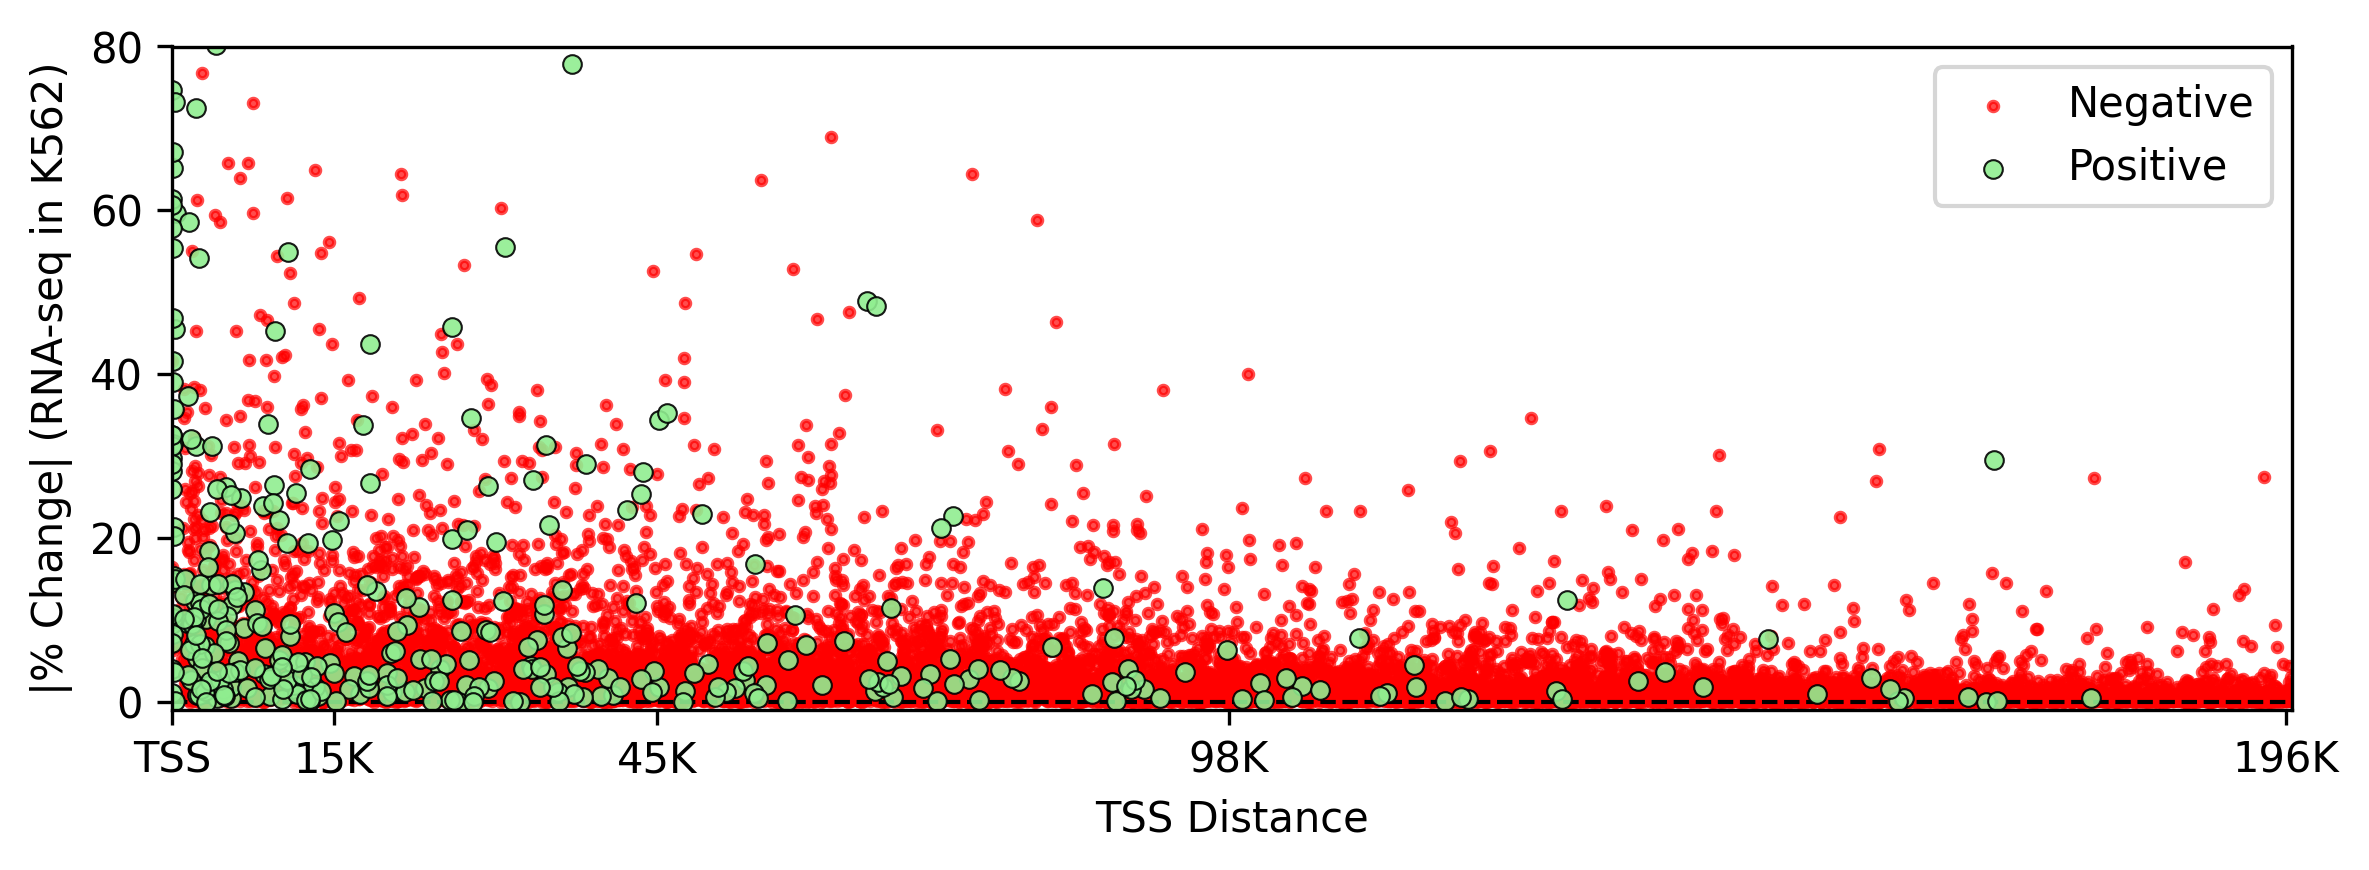

In [4]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; baseline) --")

#Compute and print accuracy stats
stats_df_miborzoi_baseline_ism = accuracy_stats(
    crispr_df_miborzoi_baseline_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_baseline_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_baseline_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; human_all) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.7264	0.4173	0.7016	0.4438	0.6810	0.7250	0.7712	0.3452	0.4177	0.4855
45000	2417	102	0.6331	0.0808	0.5318	0.0613	0.5756	0.6326	0.6895	0.0569	0.0846	0.1260
98000	4005	64	0.6354	0.0358	0.5768	0.0227	0.5728	0.6379	0.6970	0.0223	0.0386	0.0657
196608	5738	32	0.5855	0.0113	0.6135	0.0088	0.4677	0.5814	0.6916	0.0053	0.0124	0.0291
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	2.9933	2.4731	2.9887	3.5883
45000	2417	102	1.8208	1.3403	1.7942	2.3380
98000	4005	64	1.9589	1.3410	1.9518	2.6693
196608	5738	32	1.9265	0.9977	1.8783	3.0607


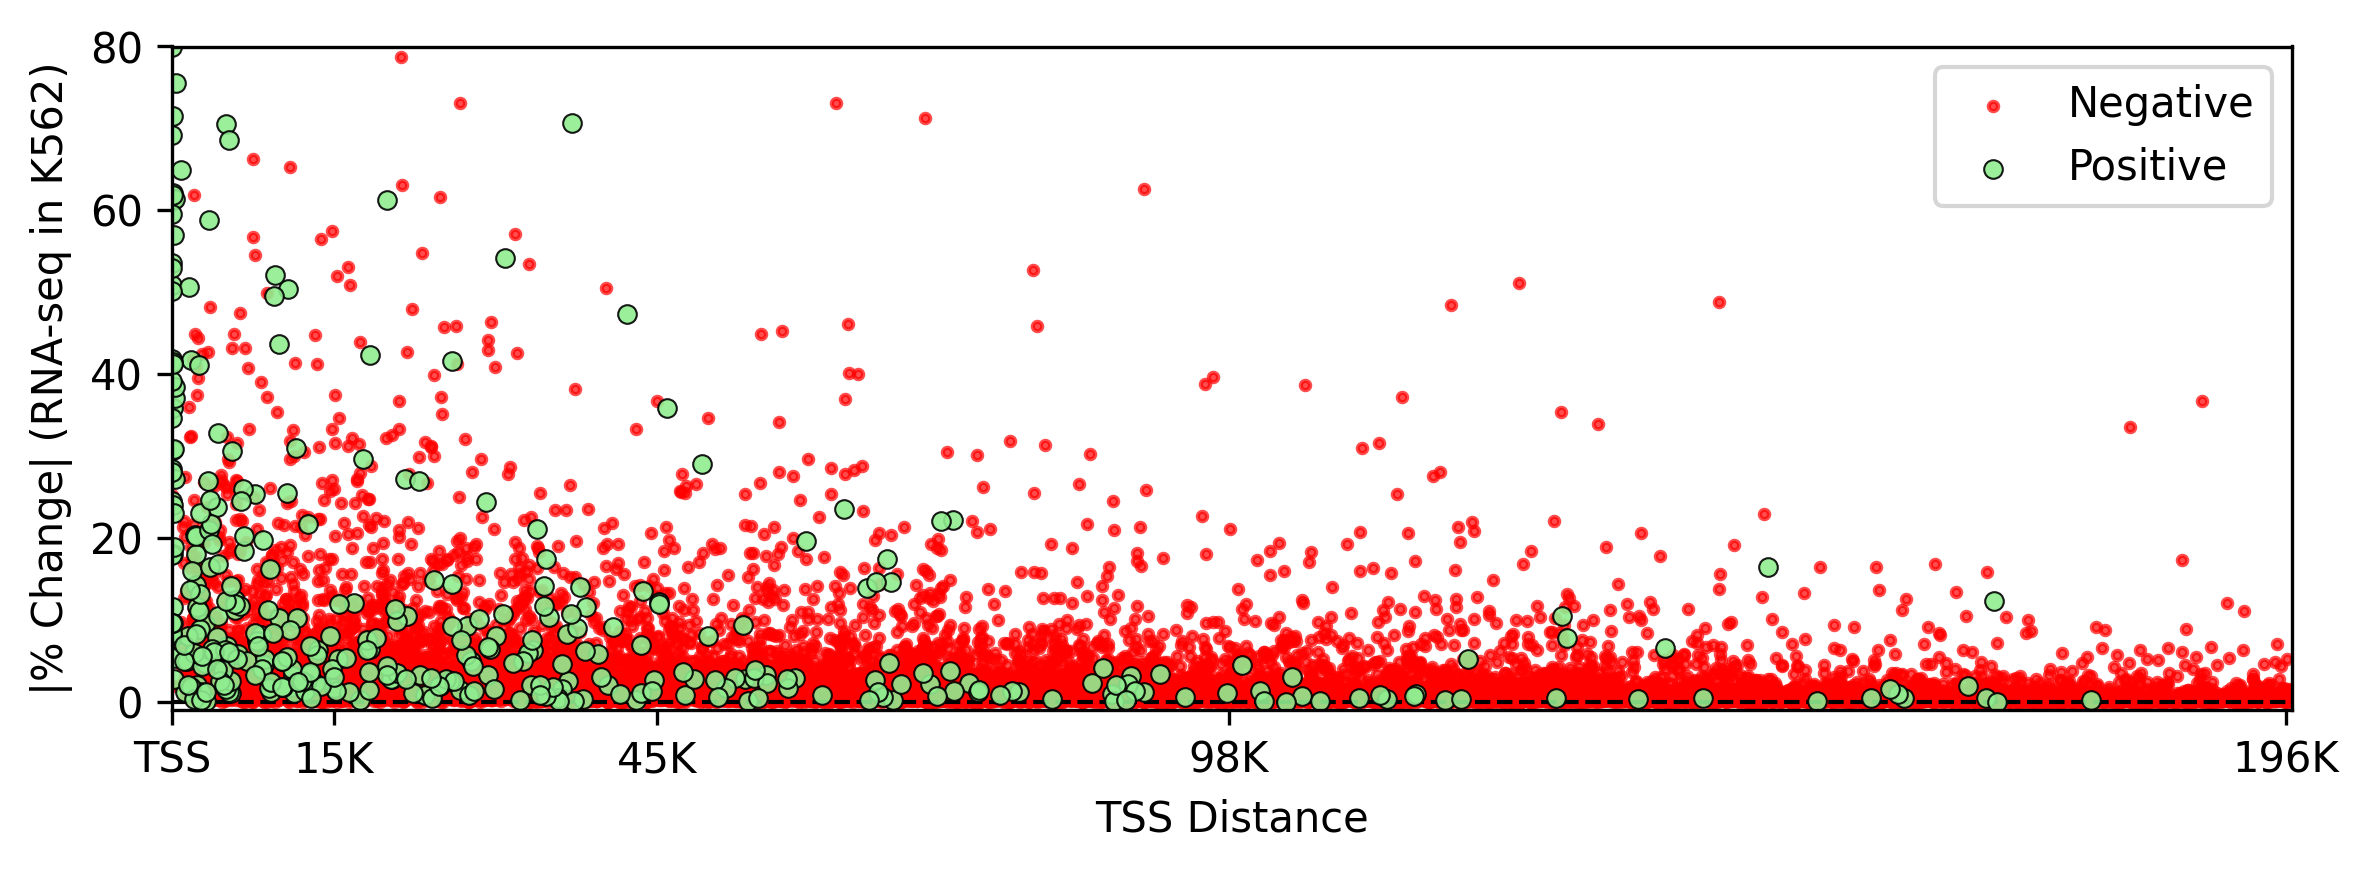

In [5]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; human_all) --")

#Compute and print accuracy stats
stats_df_miborzoi_human_all_ism = accuracy_stats(
    crispr_df_miborzoi_human_all_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_human_all_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_human_all_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; human_dnase_atac_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.6426	0.3373	0.7016	0.4438	0.5949	0.6420	0.6885	0.2700	0.3378	0.4034
45000	2417	102	0.5254	0.0512	0.5318	0.0613	0.4632	0.5244	0.5830	0.0386	0.0534	0.0742
98000	4005	64	0.4137	0.0138	0.5768	0.0227	0.3428	0.4141	0.4830	0.0102	0.0143	0.0204
196608	5738	32	0.5480	0.0079	0.6135	0.0088	0.4448	0.5479	0.6425	0.0044	0.0084	0.0224
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	2.6640	2.1079	2.6908	3.3208
45000	2417	102	1.1892	0.8635	1.1705	1.5391
98000	4005	64	0.7308	0.4630	0.7194	1.0520
196608	5738	32	1.2923	0.6225	1.2028	2.3488


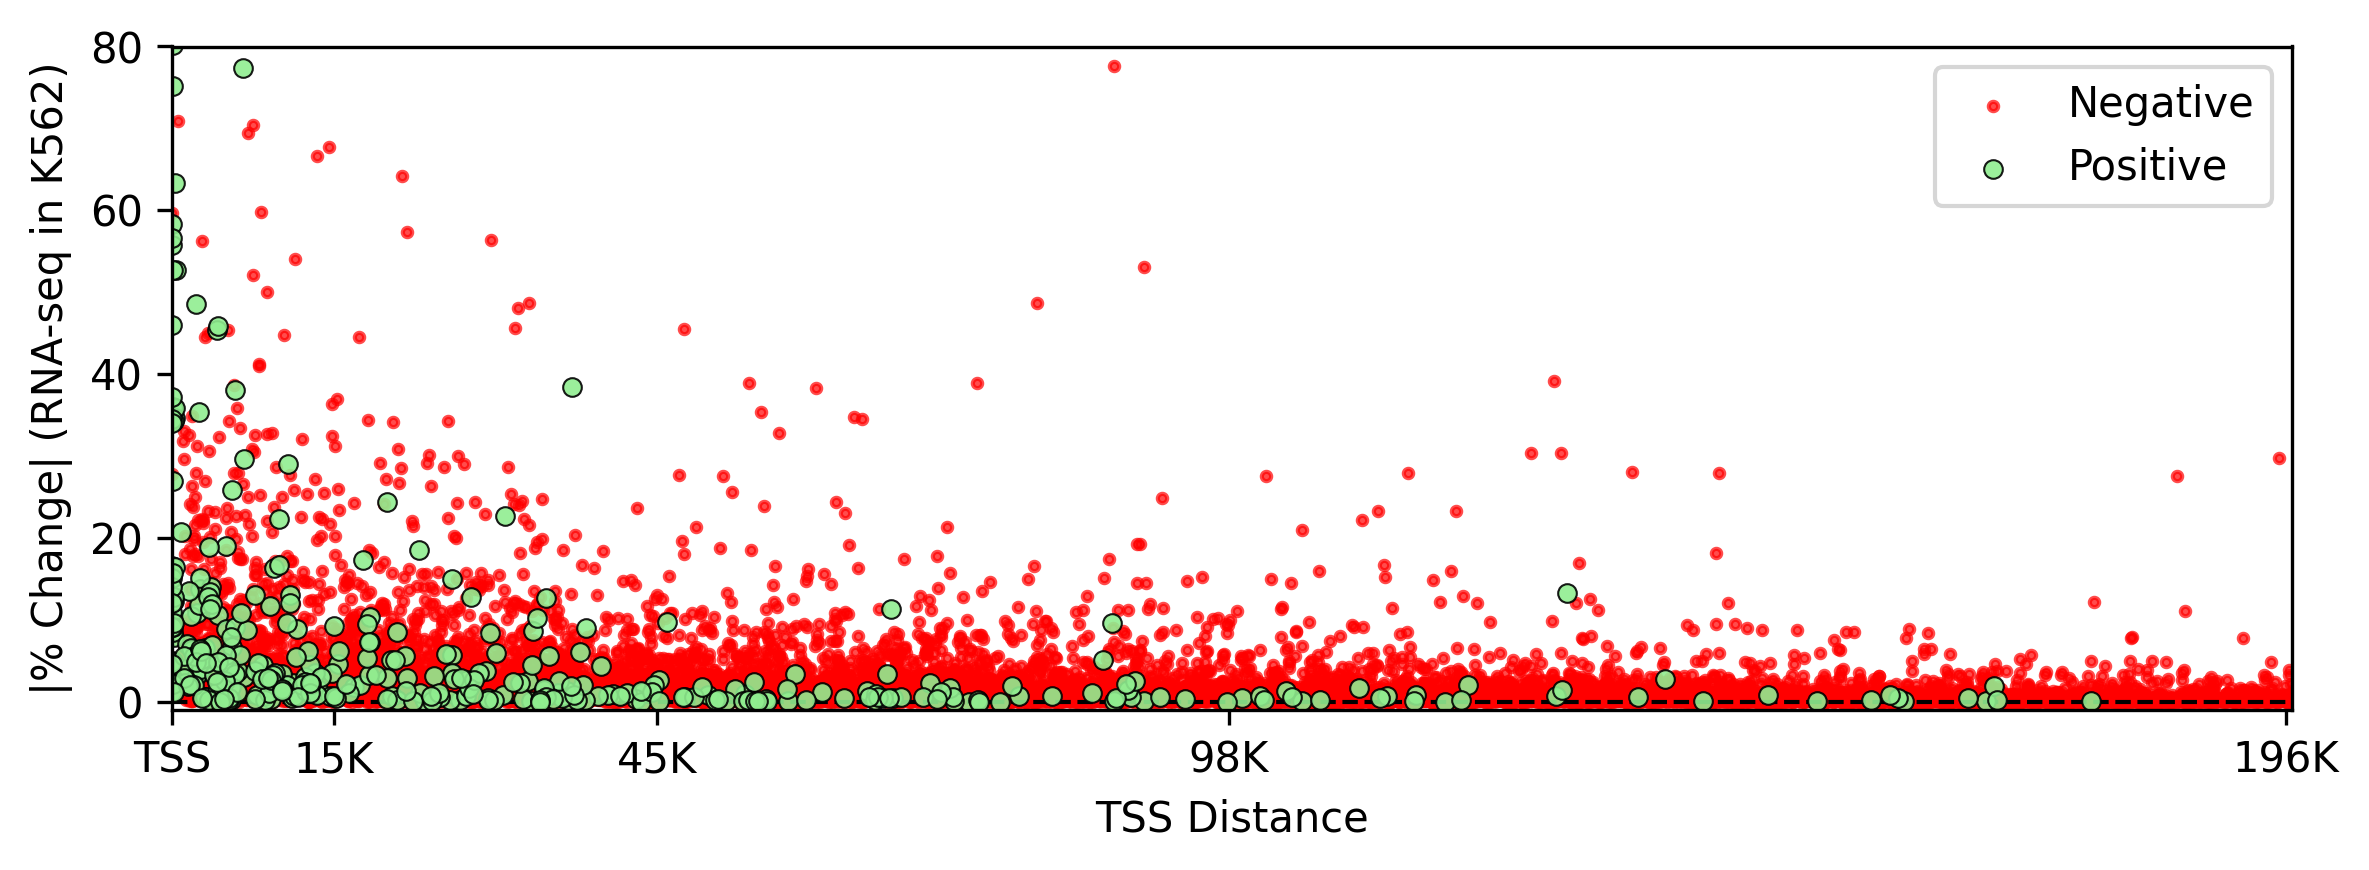

In [6]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; human_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_human_dnase_atac_rna_ism = accuracy_stats(
    crispr_df_miborzoi_human_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_human_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_human_dnase_atac_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; k562_all) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.7020	0.3827	0.7016	0.4438	0.6575	0.7026	0.7432	0.3184	0.3850	0.4510
45000	2417	102	0.6151	0.0756	0.5318	0.0613	0.5614	0.6137	0.6710	0.0551	0.0783	0.1186
98000	4005	64	0.5930	0.0871	0.5768	0.0227	0.5202	0.5968	0.6710	0.0329	0.0899	0.1642
196608	5738	32	0.6550	0.0120	0.6135	0.0088	0.5445	0.6574	0.7478	0.0068	0.0129	0.0232
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	2.8003	2.2052	2.7924	3.5316
45000	2417	102	1.7185	1.2888	1.7035	2.2202
98000	4005	64	2.8299	1.6899	2.7829	4.3198
196608	5738	32	1.7686	1.0624	1.7438	2.6471


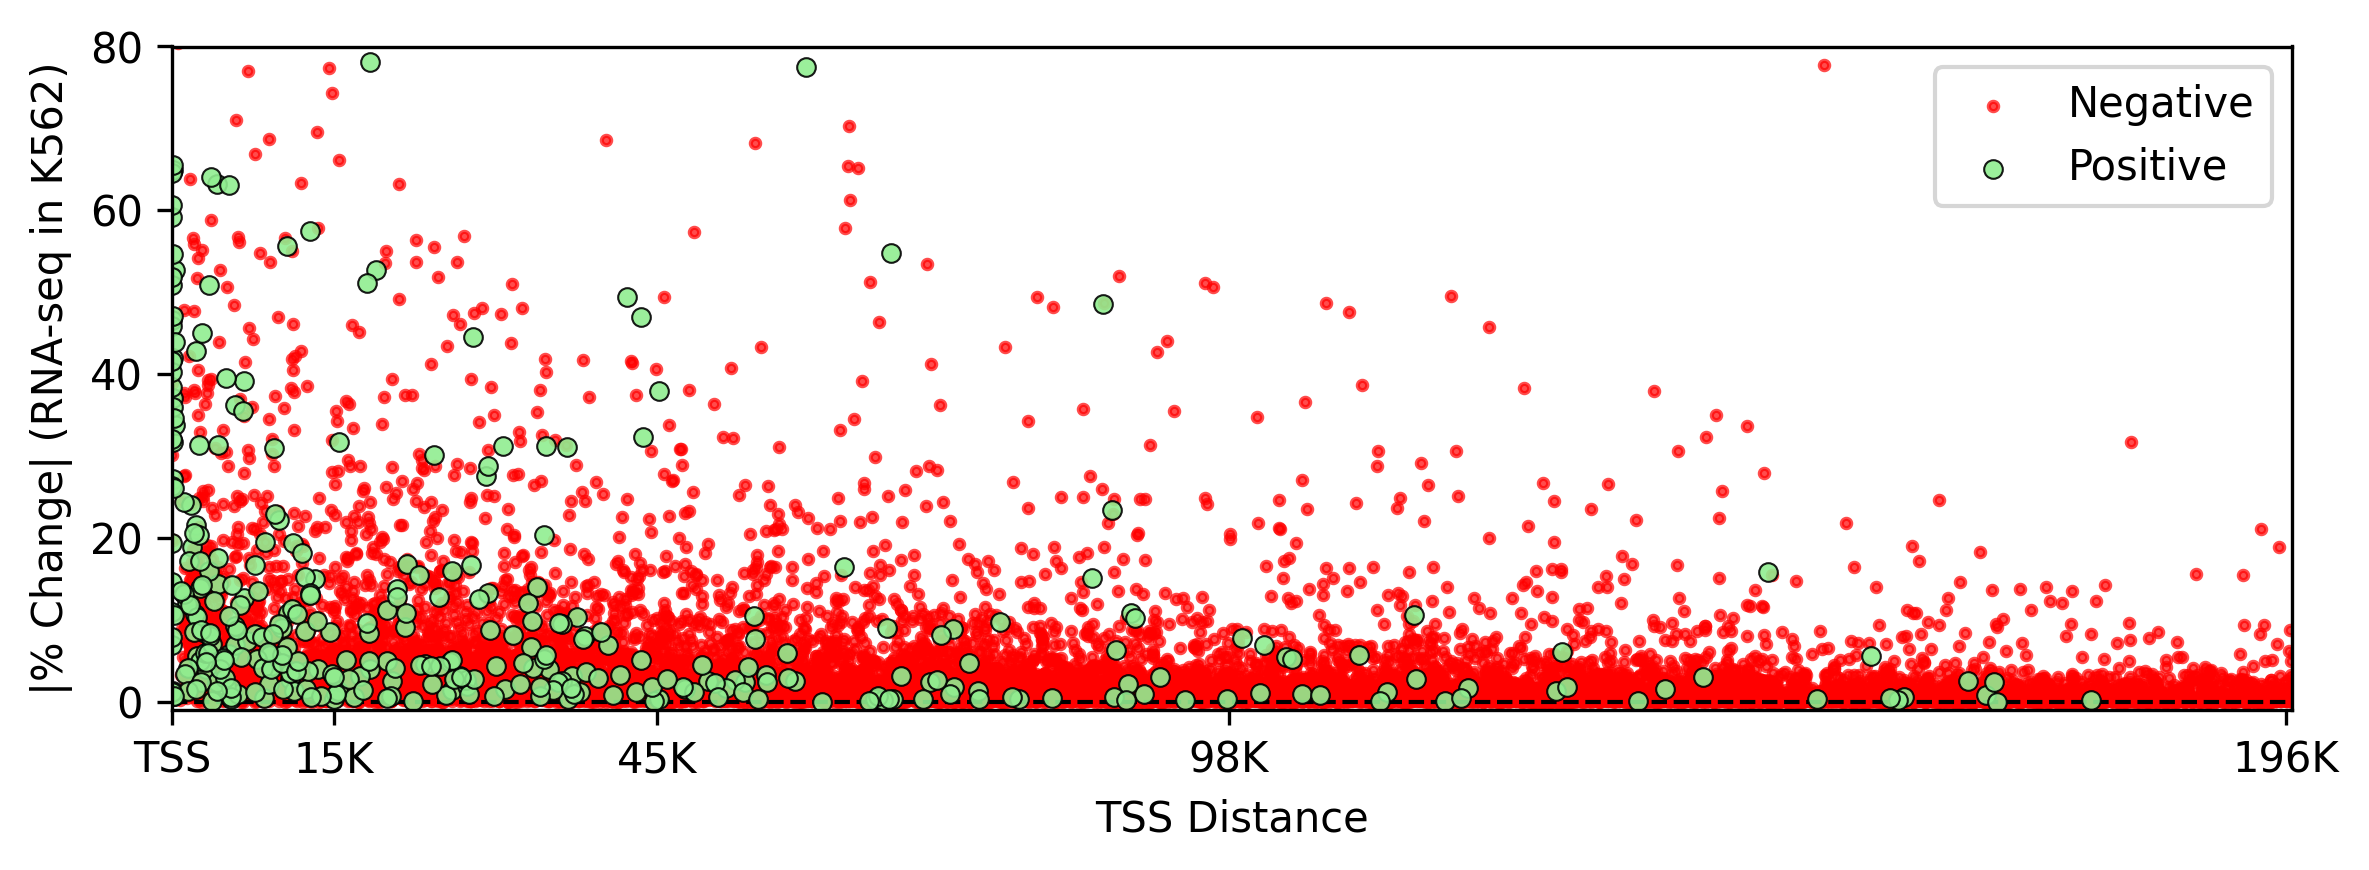

In [7]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; k562_all) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_all_ism = accuracy_stats(
    crispr_df_miborzoi_k562_all_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_k562_all_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_k562_all_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; k562_dnase_atac_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.6809	0.3937	0.7016	0.4438	0.6301	0.6811	0.7290	0.3232	0.3965	0.4674
45000	2417	102	0.5763	0.0528	0.5318	0.0613	0.5192	0.5751	0.6339	0.0415	0.0547	0.0728
98000	4005	64	0.5825	0.0325	0.5768	0.0227	0.4966	0.5806	0.6630	0.0198	0.0344	0.0649
196608	5738	32	0.5640	0.0169	0.6135	0.0088	0.4603	0.5686	0.6769	0.0058	0.0182	0.0667
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	3.0222	2.4356	3.0157	3.7024
45000	2417	102	1.1371	0.9215	1.1339	1.3962
98000	4005	64	1.7518	1.2083	1.7365	2.4994
196608	5738	32	2.6379	0.8722	2.3907	5.1594


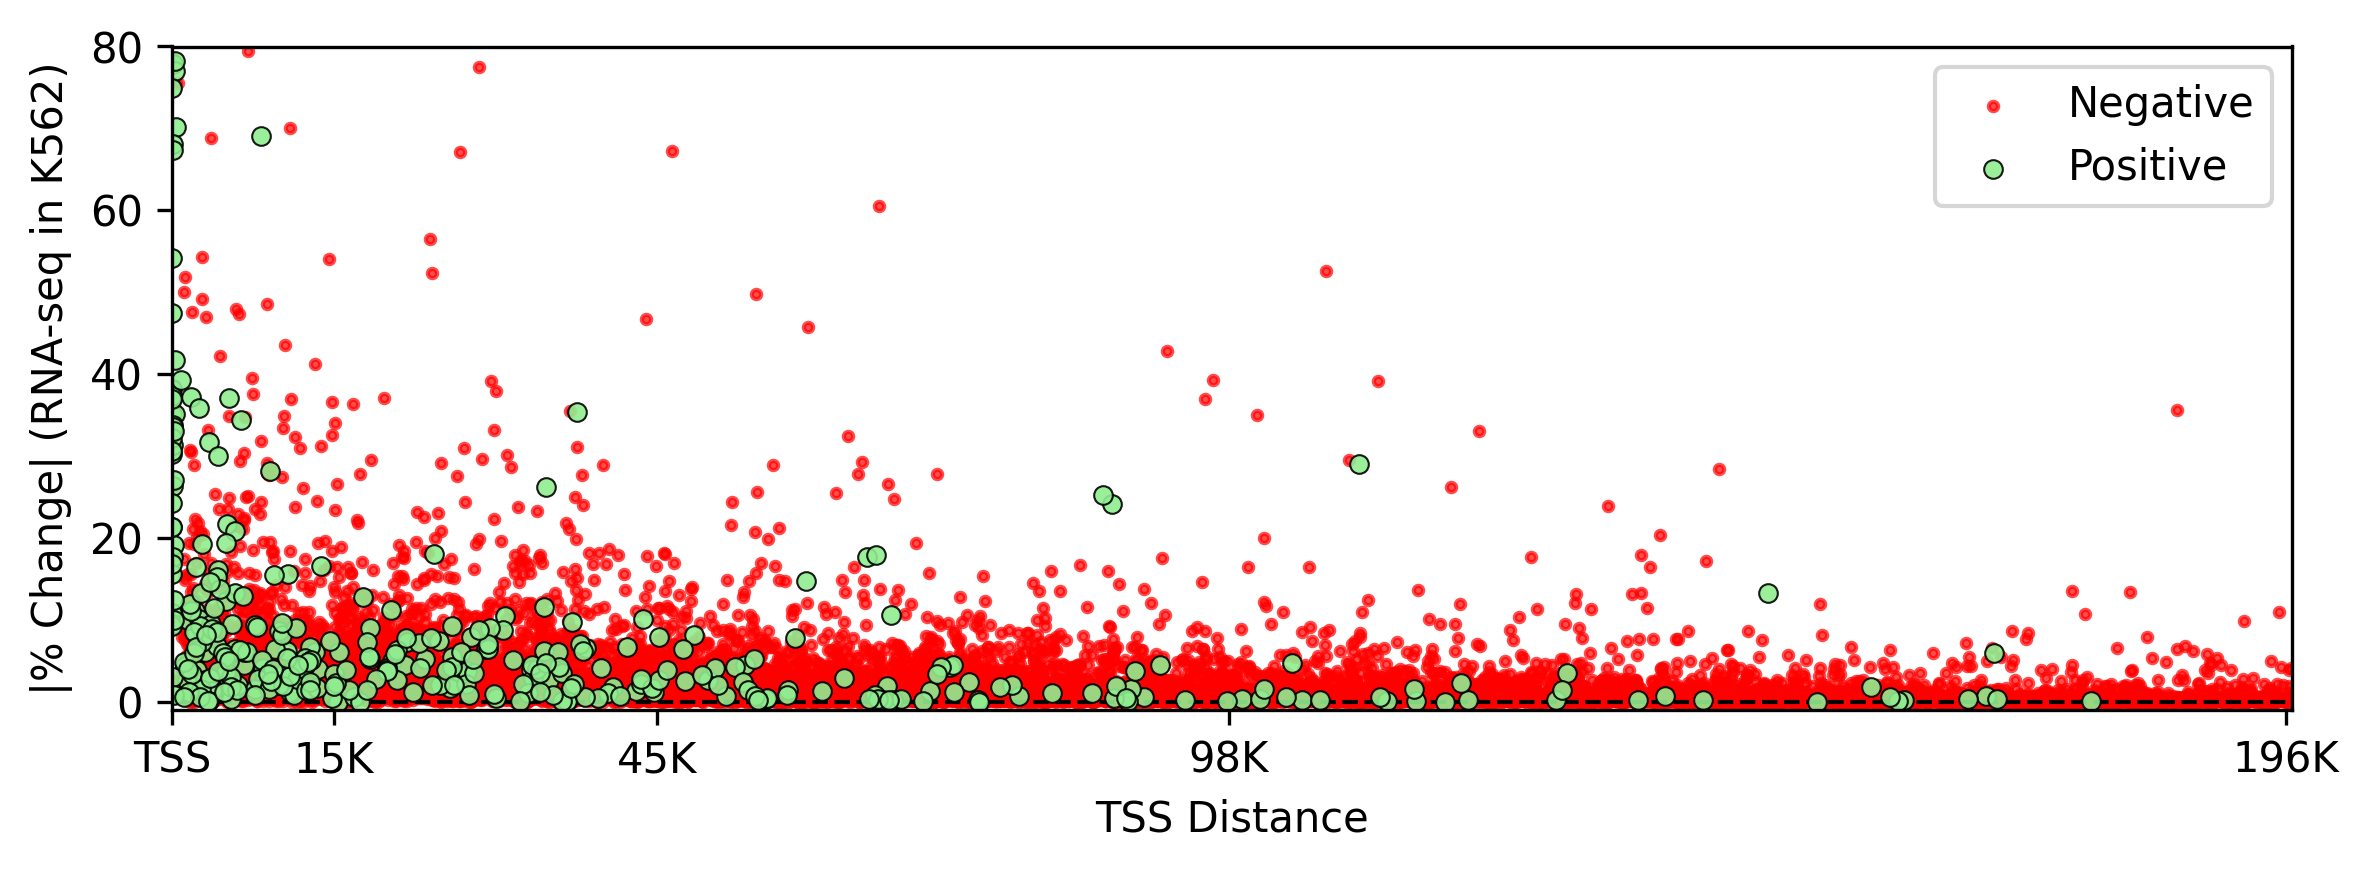

In [8]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; k562_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_dnase_atac_rna_ism = accuracy_stats(
    crispr_df_miborzoi_k562_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_k562_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_k562_dnase_atac_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; k562_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.6228	0.3303	0.7016	0.4438	0.5759	0.6239	0.6729	0.2695	0.3317	0.4029
45000	2417	102	0.4867	0.0419	0.5318	0.0613	0.4314	0.4859	0.5382	0.0324	0.0429	0.0631
98000	4005	64	0.4422	0.0152	0.5768	0.0227	0.3682	0.4409	0.5169	0.0109	0.0158	0.0222
196608	5738	32	0.5567	0.0093	0.6135	0.0088	0.4553	0.5543	0.6514	0.0047	0.0098	0.0301
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	2.6645	1.9973	2.6729	3.3716
45000	2417	102	0.9364	0.6610	0.9300	1.3760
98000	4005	64	0.8564	0.5697	0.8530	1.1889
196608	5738	32	1.5275	0.6975	1.4809	2.7381


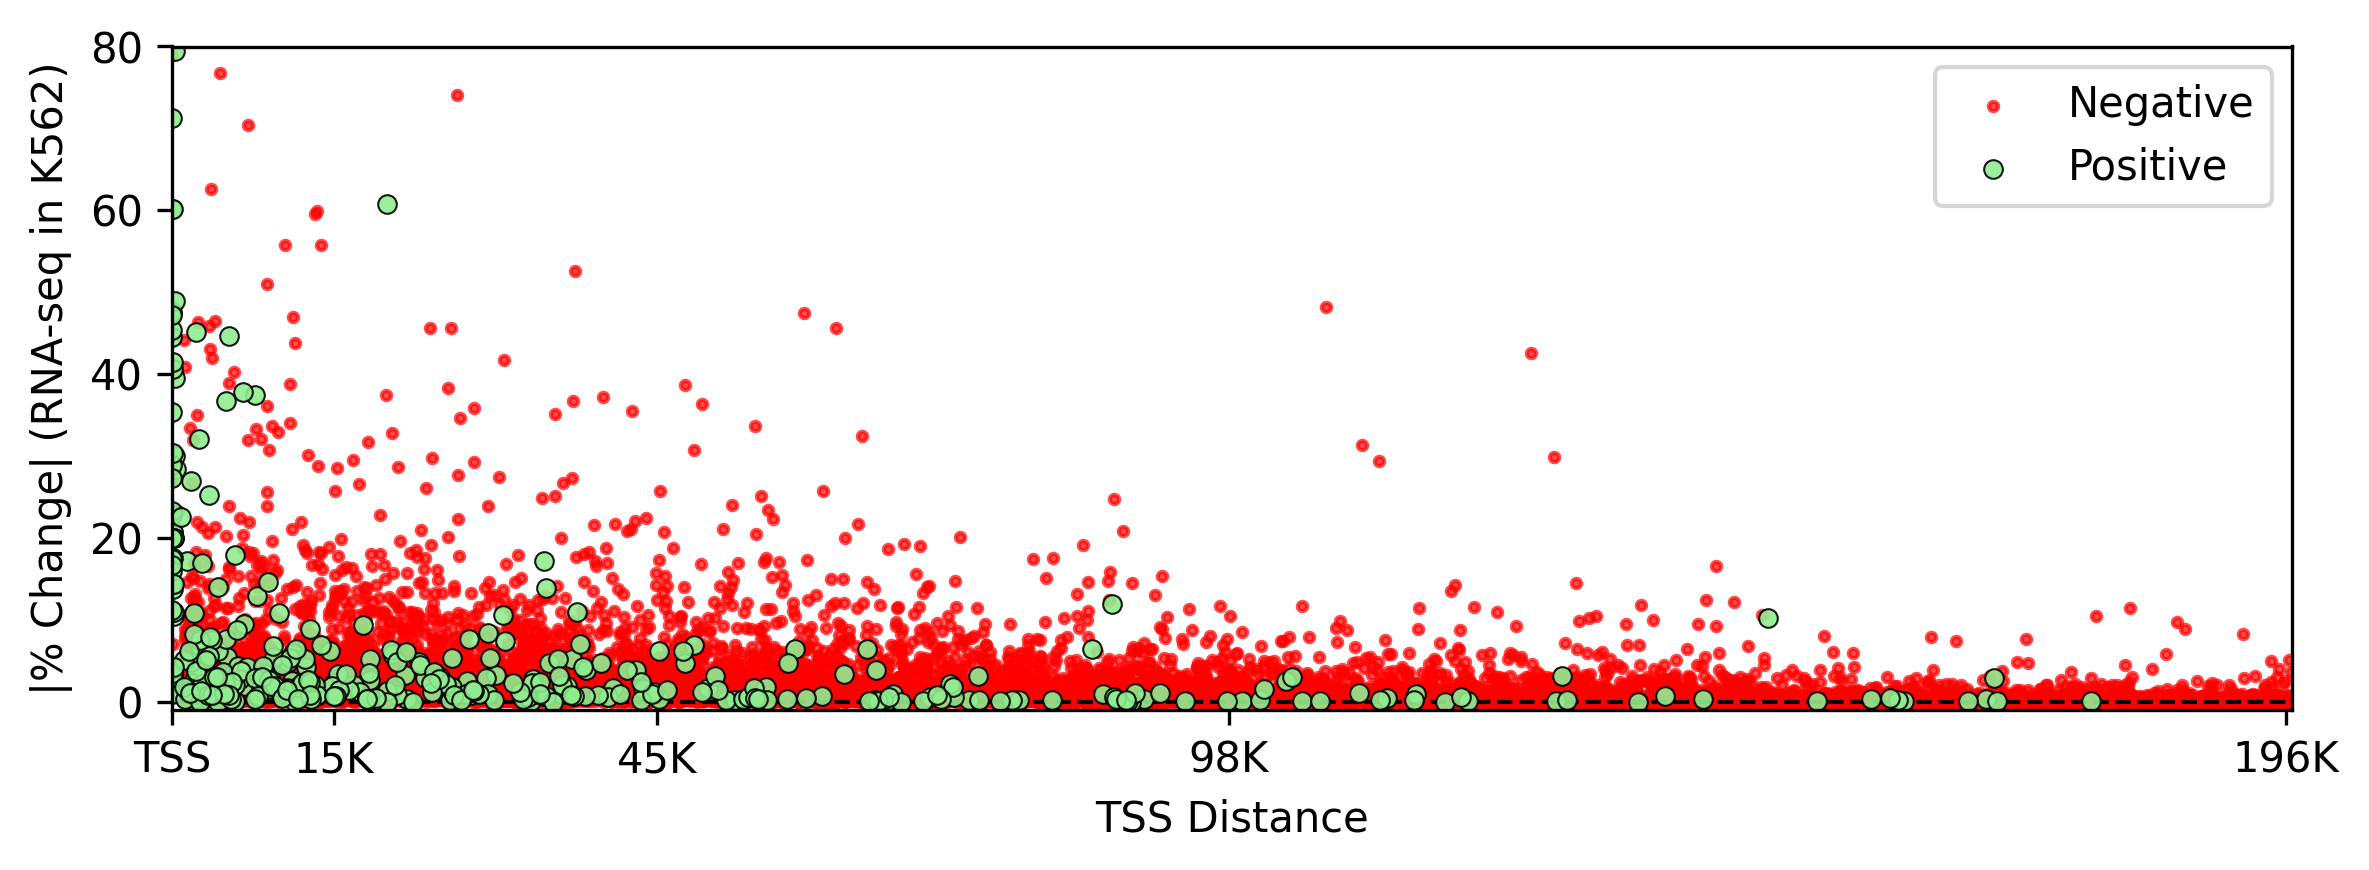

In [9]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; k562_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_k562_rna_ism = accuracy_stats(
    crispr_df_miborzoi_k562_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_k562_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_k562_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; multisp_dnase_atac_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.6977	0.4093	0.7016	0.4438	0.6529	0.6981	0.7459	0.3387	0.4136	0.4858
45000	2417	102	0.6004	0.0866	0.5318	0.0613	0.5310	0.5979	0.6634	0.0571	0.0910	0.1392
98000	4005	64	0.5924	0.0373	0.5768	0.0227	0.5207	0.5926	0.6633	0.0199	0.0403	0.0749
196608	5738	32	0.6373	0.0206	0.6135	0.0088	0.5437	0.6387	0.7311	0.0074	0.0228	0.0715
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	2.8905	2.3621	2.8993	3.5289
45000	2417	102	1.8023	1.3412	1.7878	2.3108
98000	4005	64	2.0059	1.2883	1.9929	2.8693
196608	5738	32	2.9350	1.2428	2.9466	5.0801


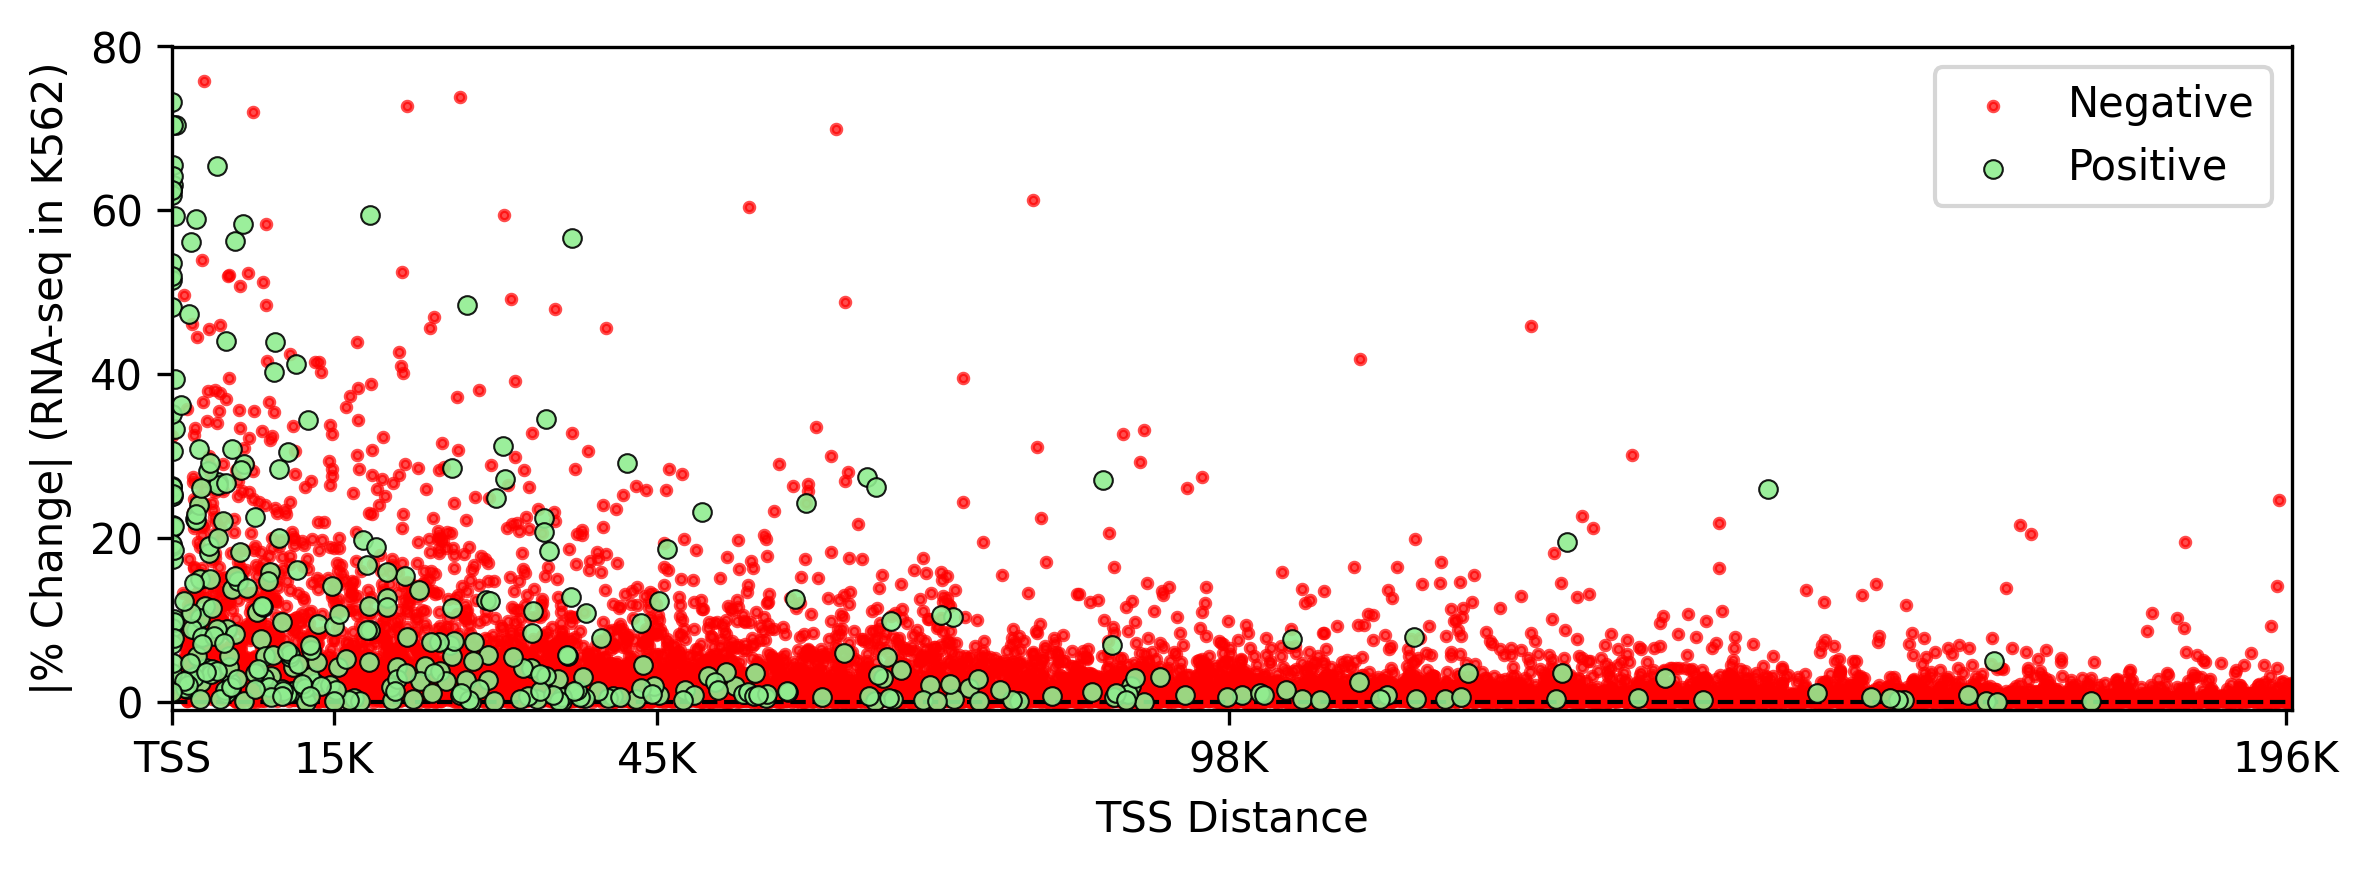

In [10]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; multisp_dnase_atac_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_dnase_atac_rna_ism = accuracy_stats(
    crispr_df_miborzoi_multisp_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_multisp_dnase_atac_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_multisp_dnase_atac_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; multisp_rna) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.6368	0.3364	0.7016	0.4438	0.5904	0.6353	0.6849	0.2725	0.3368	0.4029
45000	2417	102	0.5295	0.0457	0.5318	0.0613	0.4683	0.5283	0.5840	0.0358	0.0470	0.0599
98000	4005	64	0.5011	0.0166	0.5768	0.0227	0.4360	0.5020	0.5658	0.0125	0.0175	0.0247
196608	5738	32	0.5236	0.0091	0.6135	0.0088	0.4158	0.5223	0.6336	0.0047	0.0099	0.0249
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	2.7935	2.1504	2.8080	3.5022
45000	2417	102	0.9699	0.7692	0.9646	1.2195
98000	4005	64	0.9499	0.6508	0.9465	1.3381
196608	5738	32	1.5921	0.6262	1.5352	2.9415


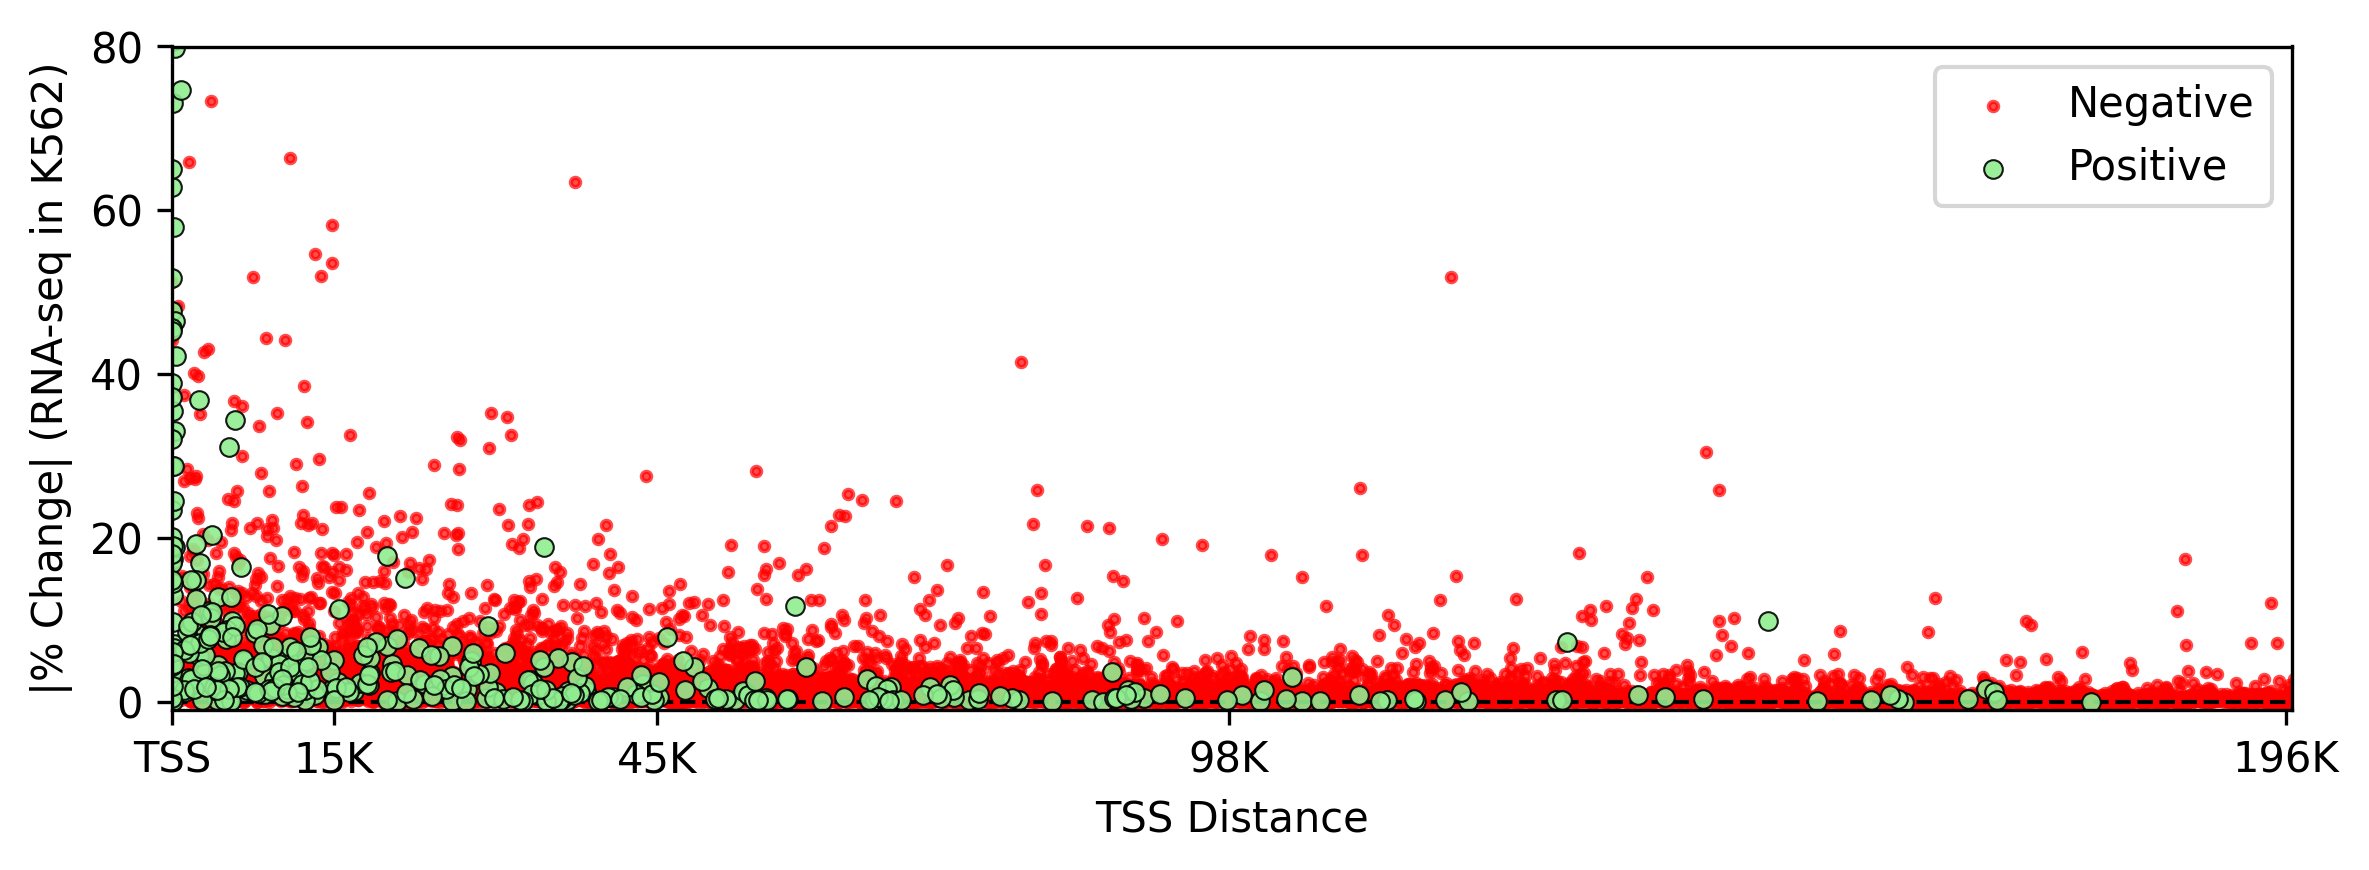

In [11]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; multisp_rna) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_rna_ism = accuracy_stats(
    crispr_df_miborzoi_multisp_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_multisp_rna_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_multisp_rna_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- mini borzoi scores (ism shuffle; multisp_no_unet) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.7348	0.4108	0.7016	0.4438	0.6927	0.7350	0.7755	0.3425	0.4152	0.4807
45000	2417	102	0.6329	0.0957	0.5318	0.0613	0.5763	0.6324	0.6870	0.0645	0.0973	0.1547
98000	4005	64	0.6228	0.0321	0.5768	0.0227	0.5504	0.6218	0.6904	0.0188	0.0337	0.0616
196608	5738	32	0.6151	0.0097	0.6135	0.0088	0.5107	0.6163	0.7204	0.0059	0.0104	0.0174
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	3.1649	2.5090	3.1813	3.9331
45000	2417	102	1.9565	1.4566	1.9434	2.5311
98000	4005	64	1.7559	1.1085	1.7342	2.5553
196608	5738	32	1.4930	0.9134	1.4901	2.0948


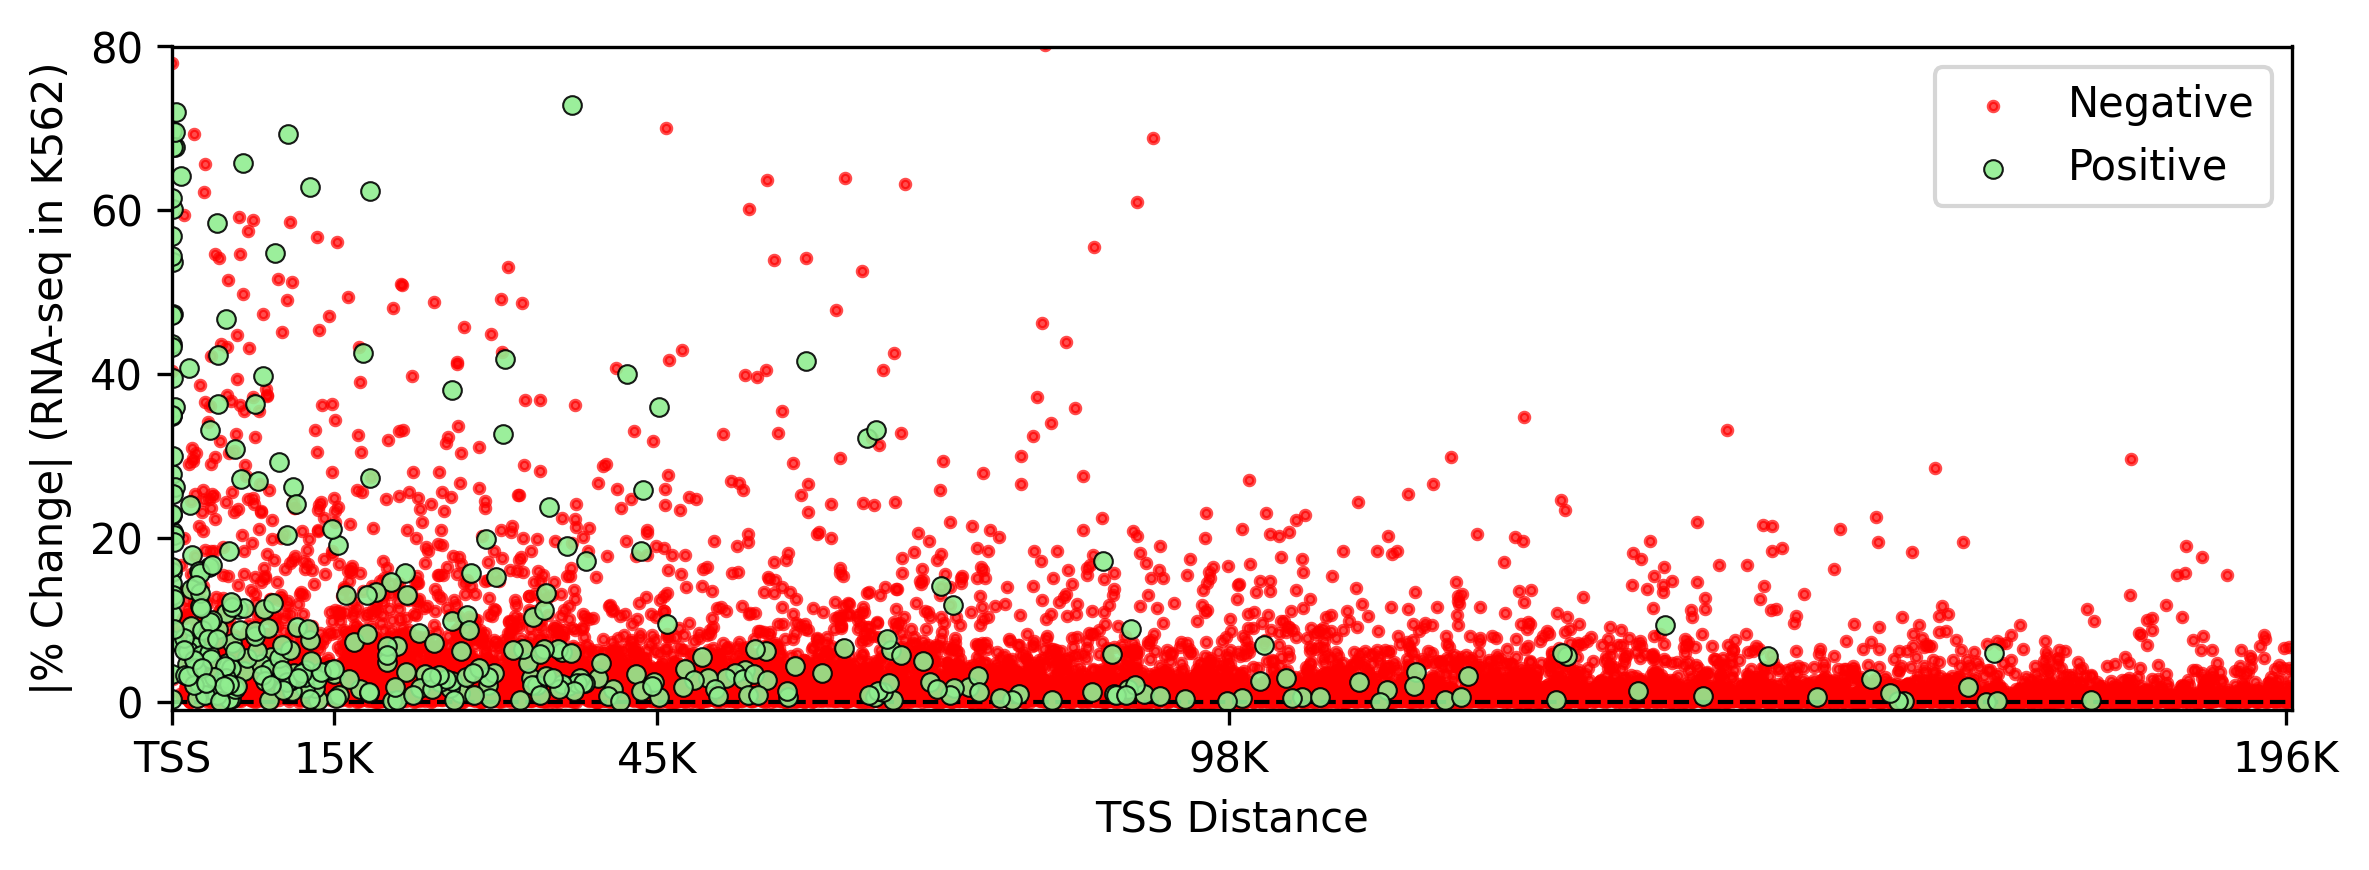

In [12]:
#Evaluate mini borzoi scores (ism shuffle; ensemble)

print("-- mini borzoi scores (ism shuffle; multisp_no_unet) --")

#Compute and print accuracy stats
stats_df_miborzoi_multisp_no_unet_ism = accuracy_stats(
    crispr_df_miborzoi_multisp_no_unet_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_miborzoi_multisp_no_unet_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_miborzoi_multisp_no_unet_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


-- borzoi scores (ism shuffle) --
dist	sites	pos	auc	ap	tss_auc	tss_ap	auc_lo	auc_med	auc_hi	ap_lo	ap_med	ap_hi
15000	1221	178	0.7406	0.4365	0.7016	0.4438	0.6947	0.7420	0.7860	0.3648	0.4429	0.5149
45000	2417	102	0.6866	0.1392	0.5318	0.0613	0.6215	0.6859	0.7468	0.0930	0.1454	0.2111
98000	4005	64	0.7343	0.0901	0.5768	0.0227	0.6605	0.7364	0.7987	0.0533	0.0952	0.1601
196608	6587	39	0.7212	0.0930	0.5918	0.0087	0.6129	0.7196	0.8130	0.0301	0.0965	0.1990
% change fold changes
dist	sites	pos	fc	fc_lo	fc_med	fc_hi
15000	1221	178	3.7478	3.0178	3.7290	4.5489
45000	2417	102	2.7402	2.1010	2.7476	3.4943
98000	4005	64	3.7038	2.6502	3.7074	4.9374
196608	6587	39	6.0700	3.2686	5.8503	9.5777


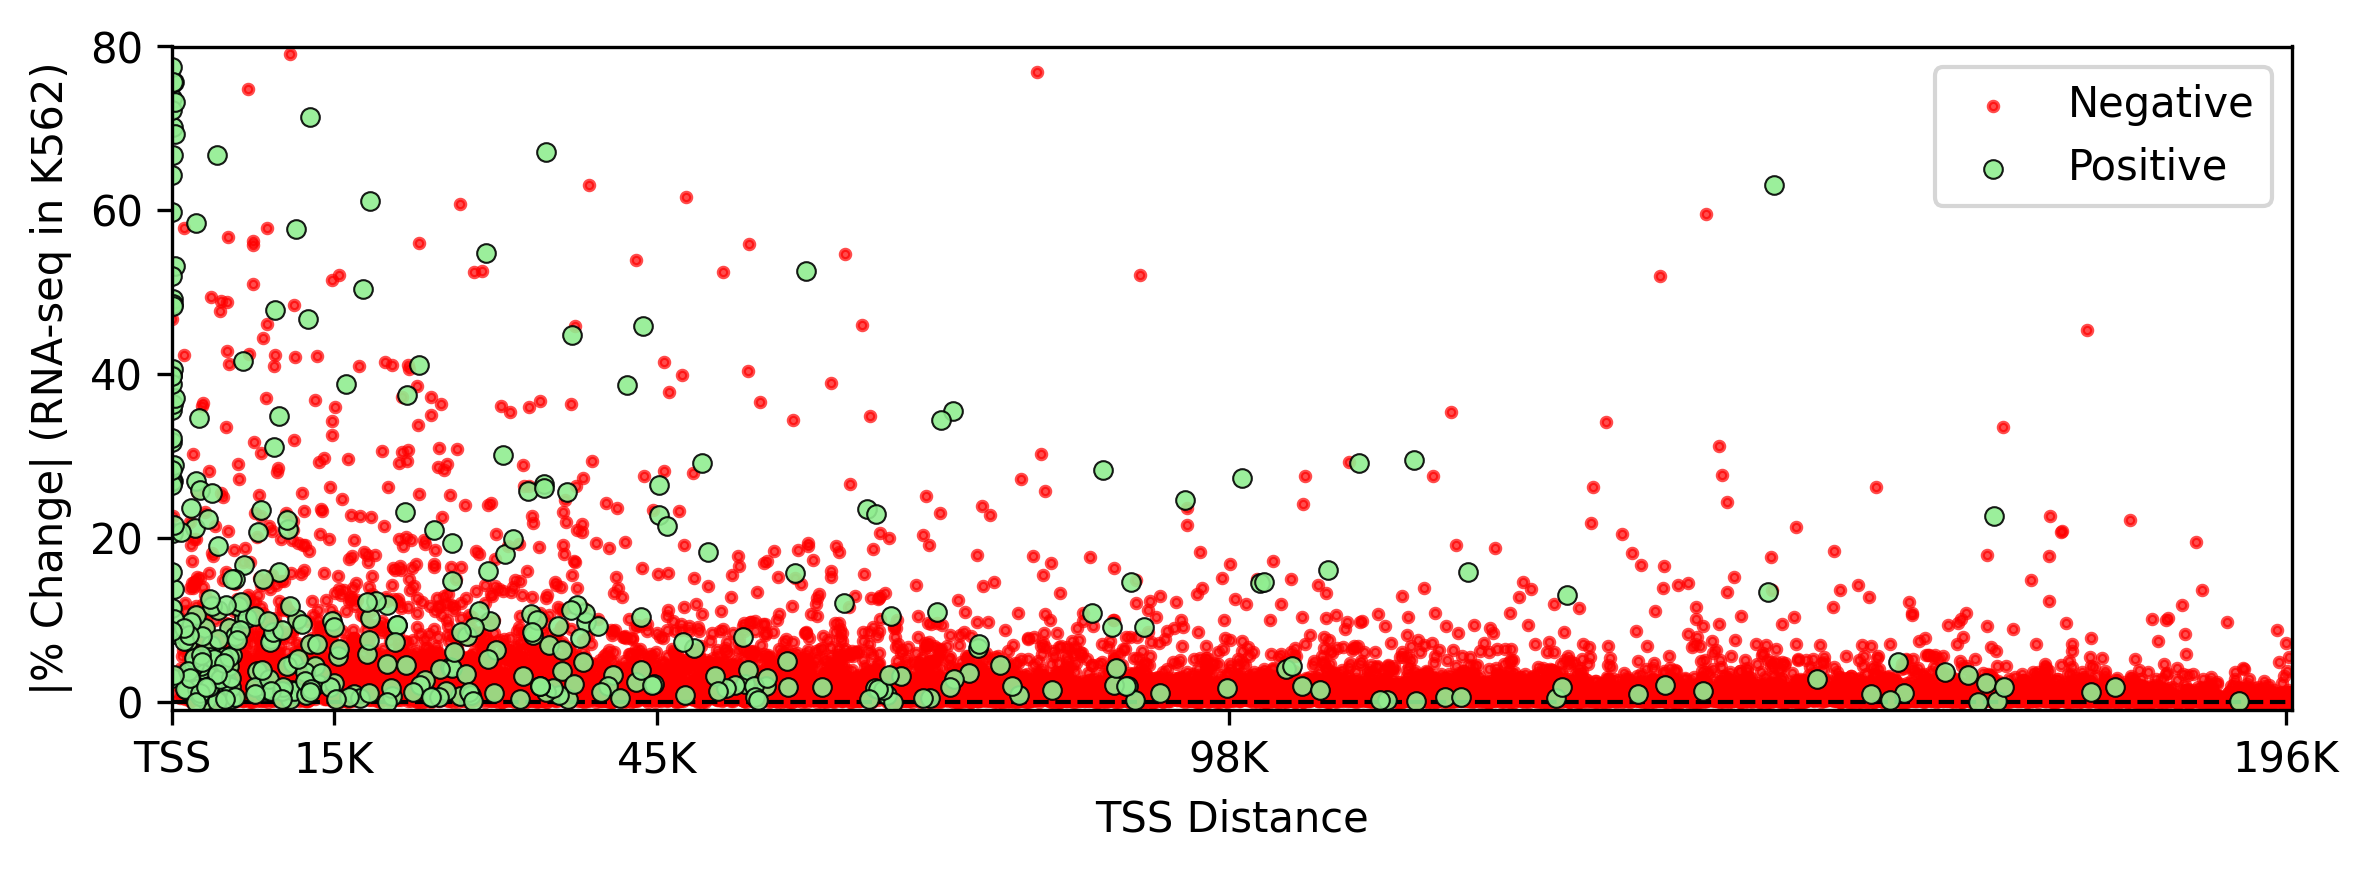

In [13]:
#Evaluate borzoi scores (ism shuffle; ensemble)

print("-- borzoi scores (ism shuffle) --")

#Compute and print accuracy stats
stats_df_borzoi_ism = accuracy_stats(
    crispr_df_borzoi_ensemble_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)
print("% change fold changes")
_ = fc_stats(
    crispr_df_borzoi_ensemble_ism,
    distance_boundaries=[0, 15000, 45000, 98000, 196608],
)

#Plot distribution of predictions for positives and negatives
crispr_df = crispr_df_borzoi_ensemble_ism

neg_df = crispr_df.query("regulate == False").copy().reset_index(drop=True)
pos_df = crispr_df.query("regulate == True").copy().reset_index(drop=True)

f = plt.figure(figsize=(8, 3), dpi=300)

plt.scatter(neg_df['tss_distance'], np.abs(neg_df['pct_change']), c='red', alpha=0.7, s=5, label='Negative', zorder=-1)
plt.scatter(pos_df['tss_distance'], np.abs(pos_df['pct_change']), c='lightgreen', s=20, alpha=0.9, edgecolor='black', linewidth=0.5, label='Positive', zorder=1)

plt.axhline(y=0., linewidth=1, linestyle='--', color='black', zorder=0)

plt.xlim(0, 196608)
plt.ylim(-1, 80)

plt.xticks([0, 15000, 45000, 98000, 196000], ['TSS', '15K', '45K', '98K', '196K'], fontsize=10)
plt.yticks([0, 20, 40, 60, 80], fontsize=10)

plt.xlabel("TSS Distance", fontsize=10)
plt.ylabel("|% Change| (RNA-seq in K562)", fontsize=10)

plt.legend(fontsize=10)

plt.tight_layout()

plt.show()


In [14]:
#Create stats dataframes for TSS baseline (no bootstrapping)

#Standard baseline
stats_df_tss = stats_df_miborzoi_k562_all_grad_gaussian[['dist', 'sites', 'pos', 'tss_auc', 'tss_ap']].copy()

stats_df_tss['auc'] = stats_df_tss['tss_auc']
stats_df_tss['ap'] = stats_df_tss['tss_ap']
stats_df_tss['auc_lo'] = stats_df_tss['auc']
stats_df_tss['auc_med'] = stats_df_tss['auc']
stats_df_tss['auc_hi'] = stats_df_tss['auc']
stats_df_tss['ap_lo'] = stats_df_tss['ap']
stats_df_tss['ap_med'] = stats_df_tss['ap']
stats_df_tss['ap_hi'] = stats_df_tss['ap']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


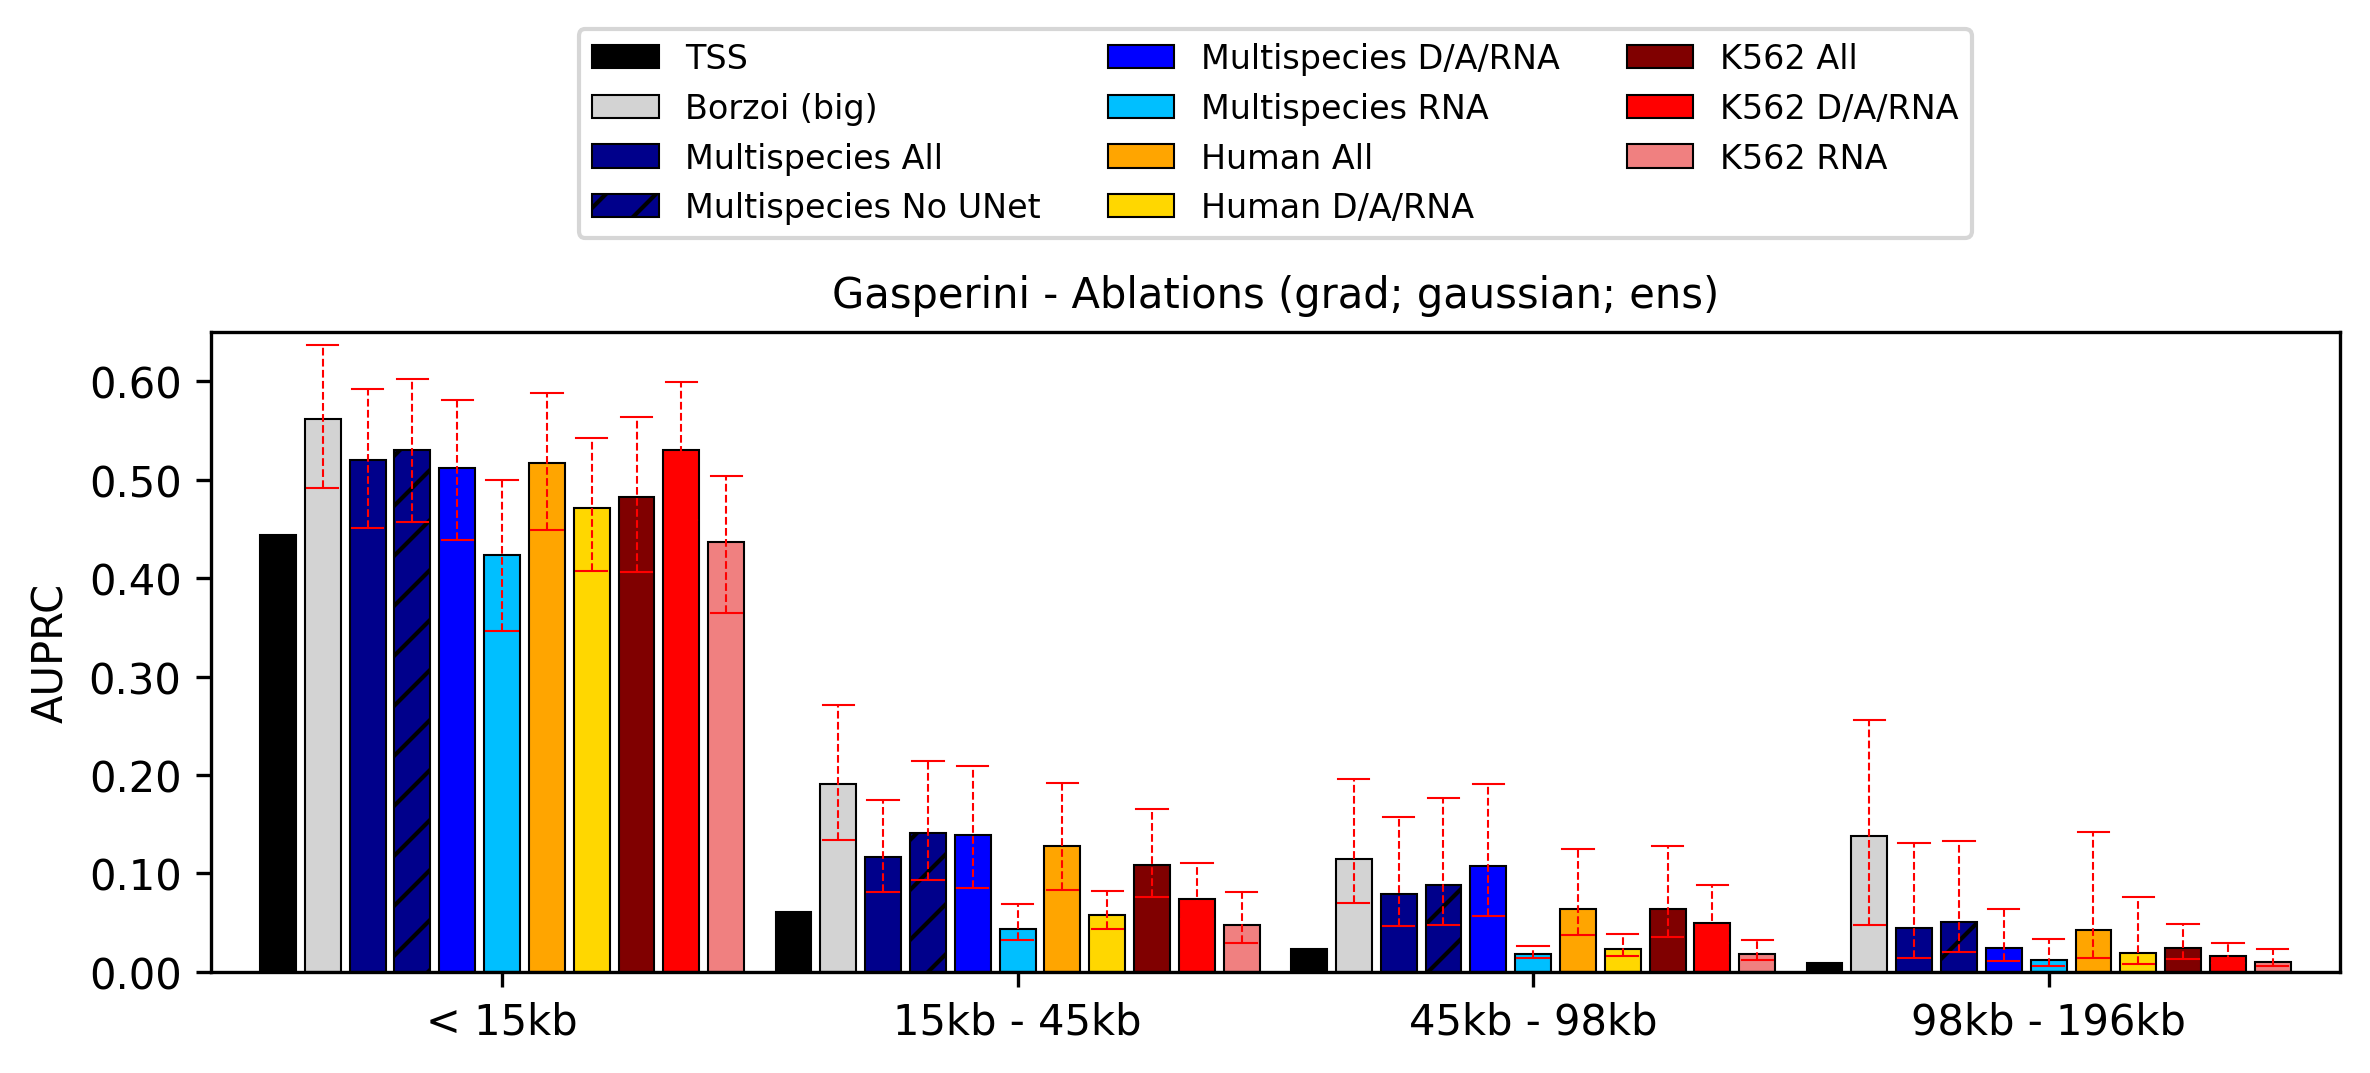

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


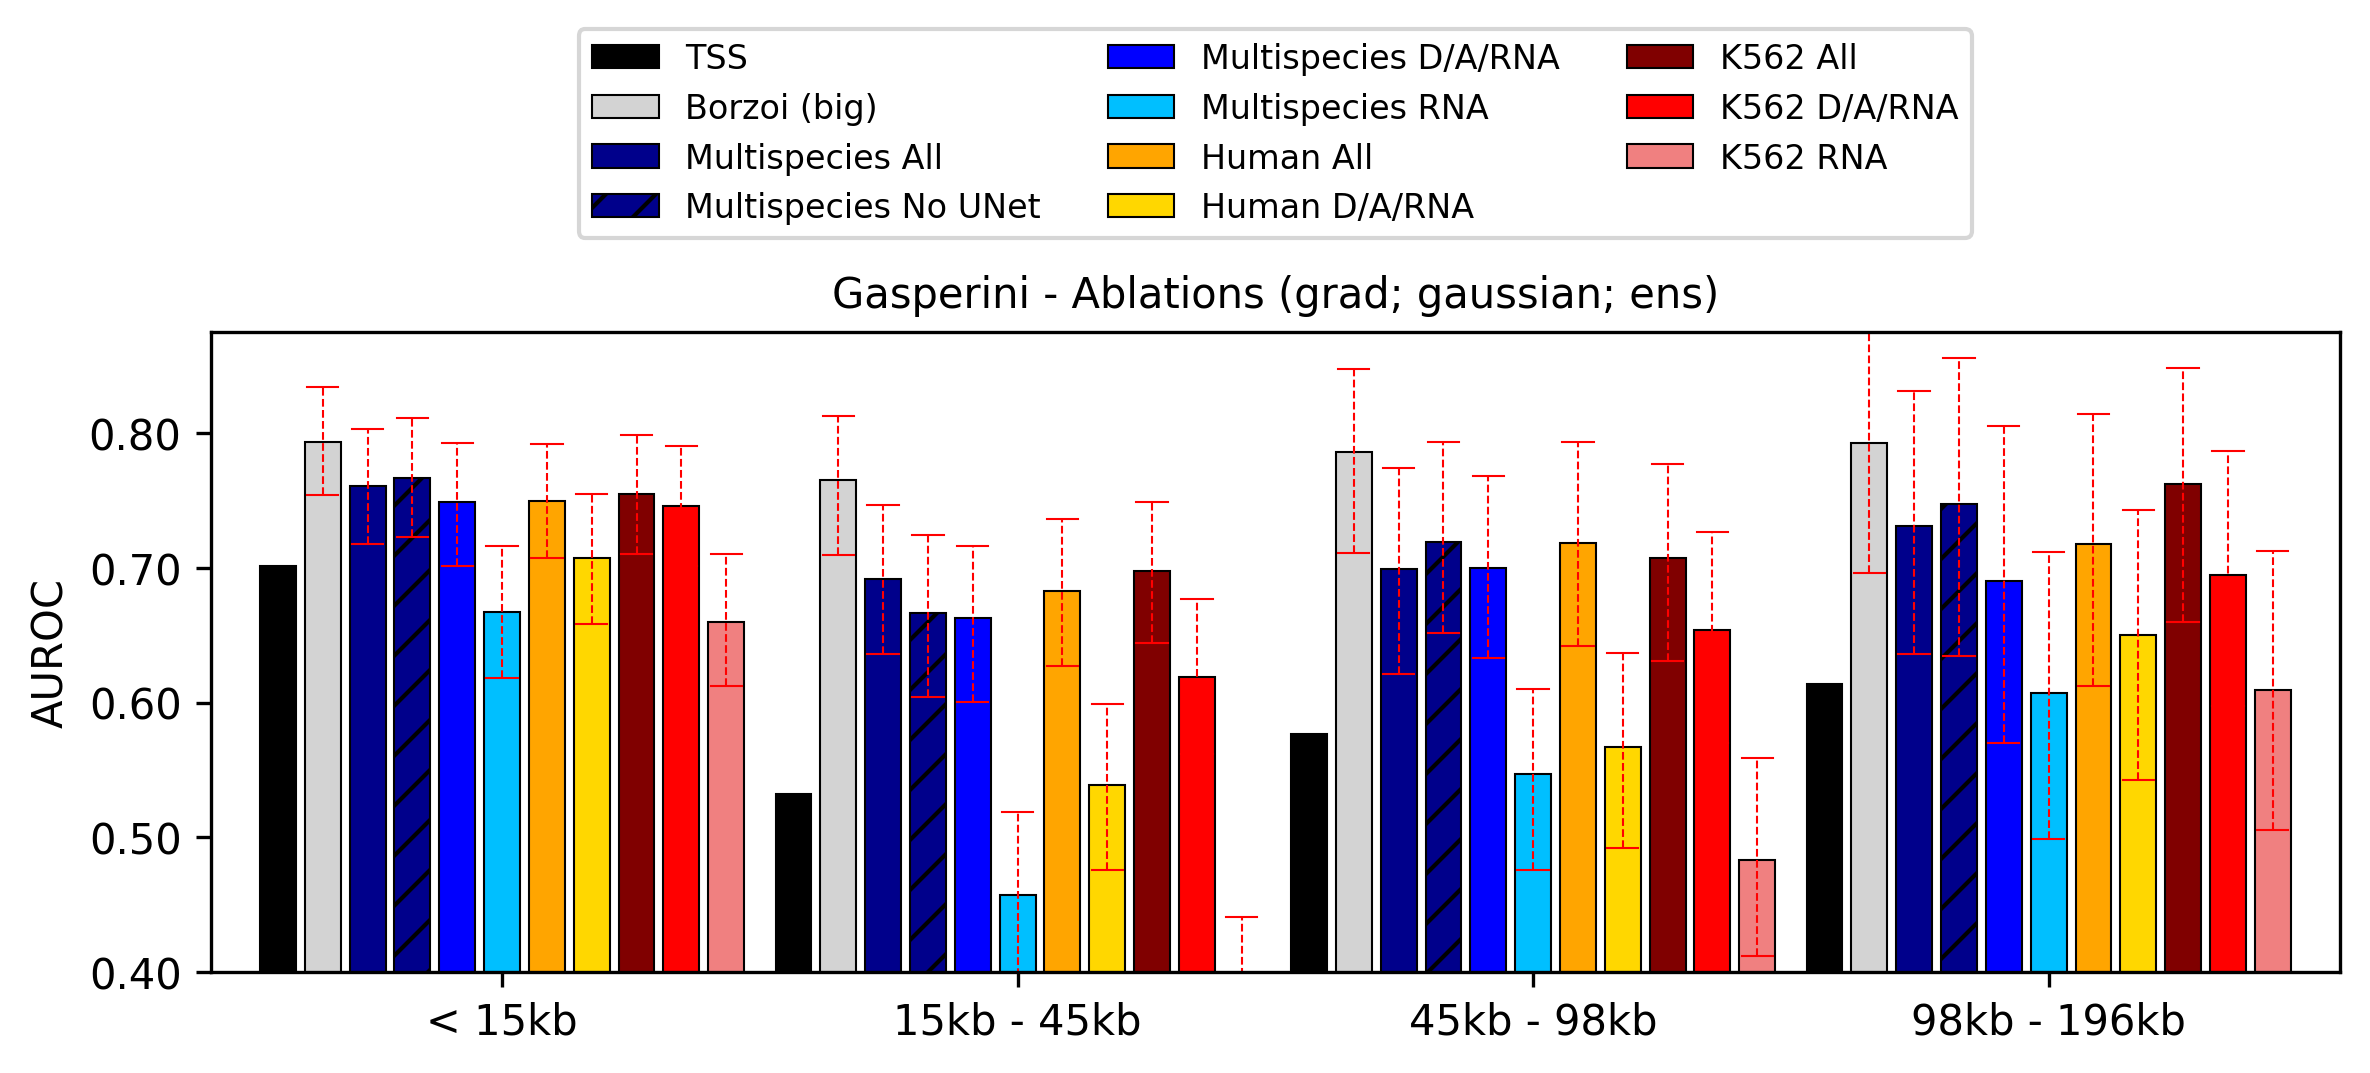

In [15]:
#Plot AUPRC bar chart with perfomance metrics (mini borzoi ablations)

#Model names
model_names = [
    'TSS',
    'Borzoi (big)',
    'Multispecies All',
    'Multispecies No UNet',
    'Multispecies D/A/RNA',
    'Multispecies RNA',
    'Human All',
    'Human D/A/RNA',
    'K562 All',
    'K562 D/A/RNA',
    'K562 RNA',
]

#Stats dataframes
model_dfs = [
    stats_df_tss,
    stats_df_borzoi_grad_gaussian,
    stats_df_miborzoi_baseline_grad_gaussian,
    stats_df_miborzoi_multisp_no_unet_grad_gaussian,
    stats_df_miborzoi_multisp_dnase_atac_rna_grad_gaussian,
    stats_df_miborzoi_multisp_rna_grad_gaussian,
    stats_df_miborzoi_human_all_grad_gaussian,
    stats_df_miborzoi_human_dnase_atac_rna_grad_gaussian,
    stats_df_miborzoi_k562_all_grad_gaussian,
    stats_df_miborzoi_k562_dnase_atac_rna_grad_gaussian,
    stats_df_miborzoi_k562_rna_grad_gaussian,
]

#Model colors
model_colors = [
    'black',
    'lightgray',
    'darkblue',
    'darkblue',
    'blue',
    'deepskyblue',
    'orange',
    'gold',
    'maroon',
    'red',
    'lightcoral',
]

#Model hatch texture
model_hatches = [
    None,
    None,
    None,
    '//',
    None,
    None,
    None,
    None,
    None,
    None,
    None,
]

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='Gasperini - Ablations (grad; gaussian; ens)',
    metric='ap',
    metric_str='AUPRC',
    distances=[15000, 45000, 98000, 196000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 196kb'],
    y_min=0.0,
    y_max=0.65,
    save_name='gasperini_miborzoi_grad_bench_prc_w_borzoi'
)

#Plot AUROC bar chart

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='Gasperini - Ablations (grad; gaussian; ens)',
    metric='auc',
    metric_str='AUROC',
    distances=[15000, 45000, 98000, 196000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 196kb'],
    y_min=0.4,
    y_max=0.875,
    save_name='gasperini_miborzoi_grad_bench_roc_w_borzoi'
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


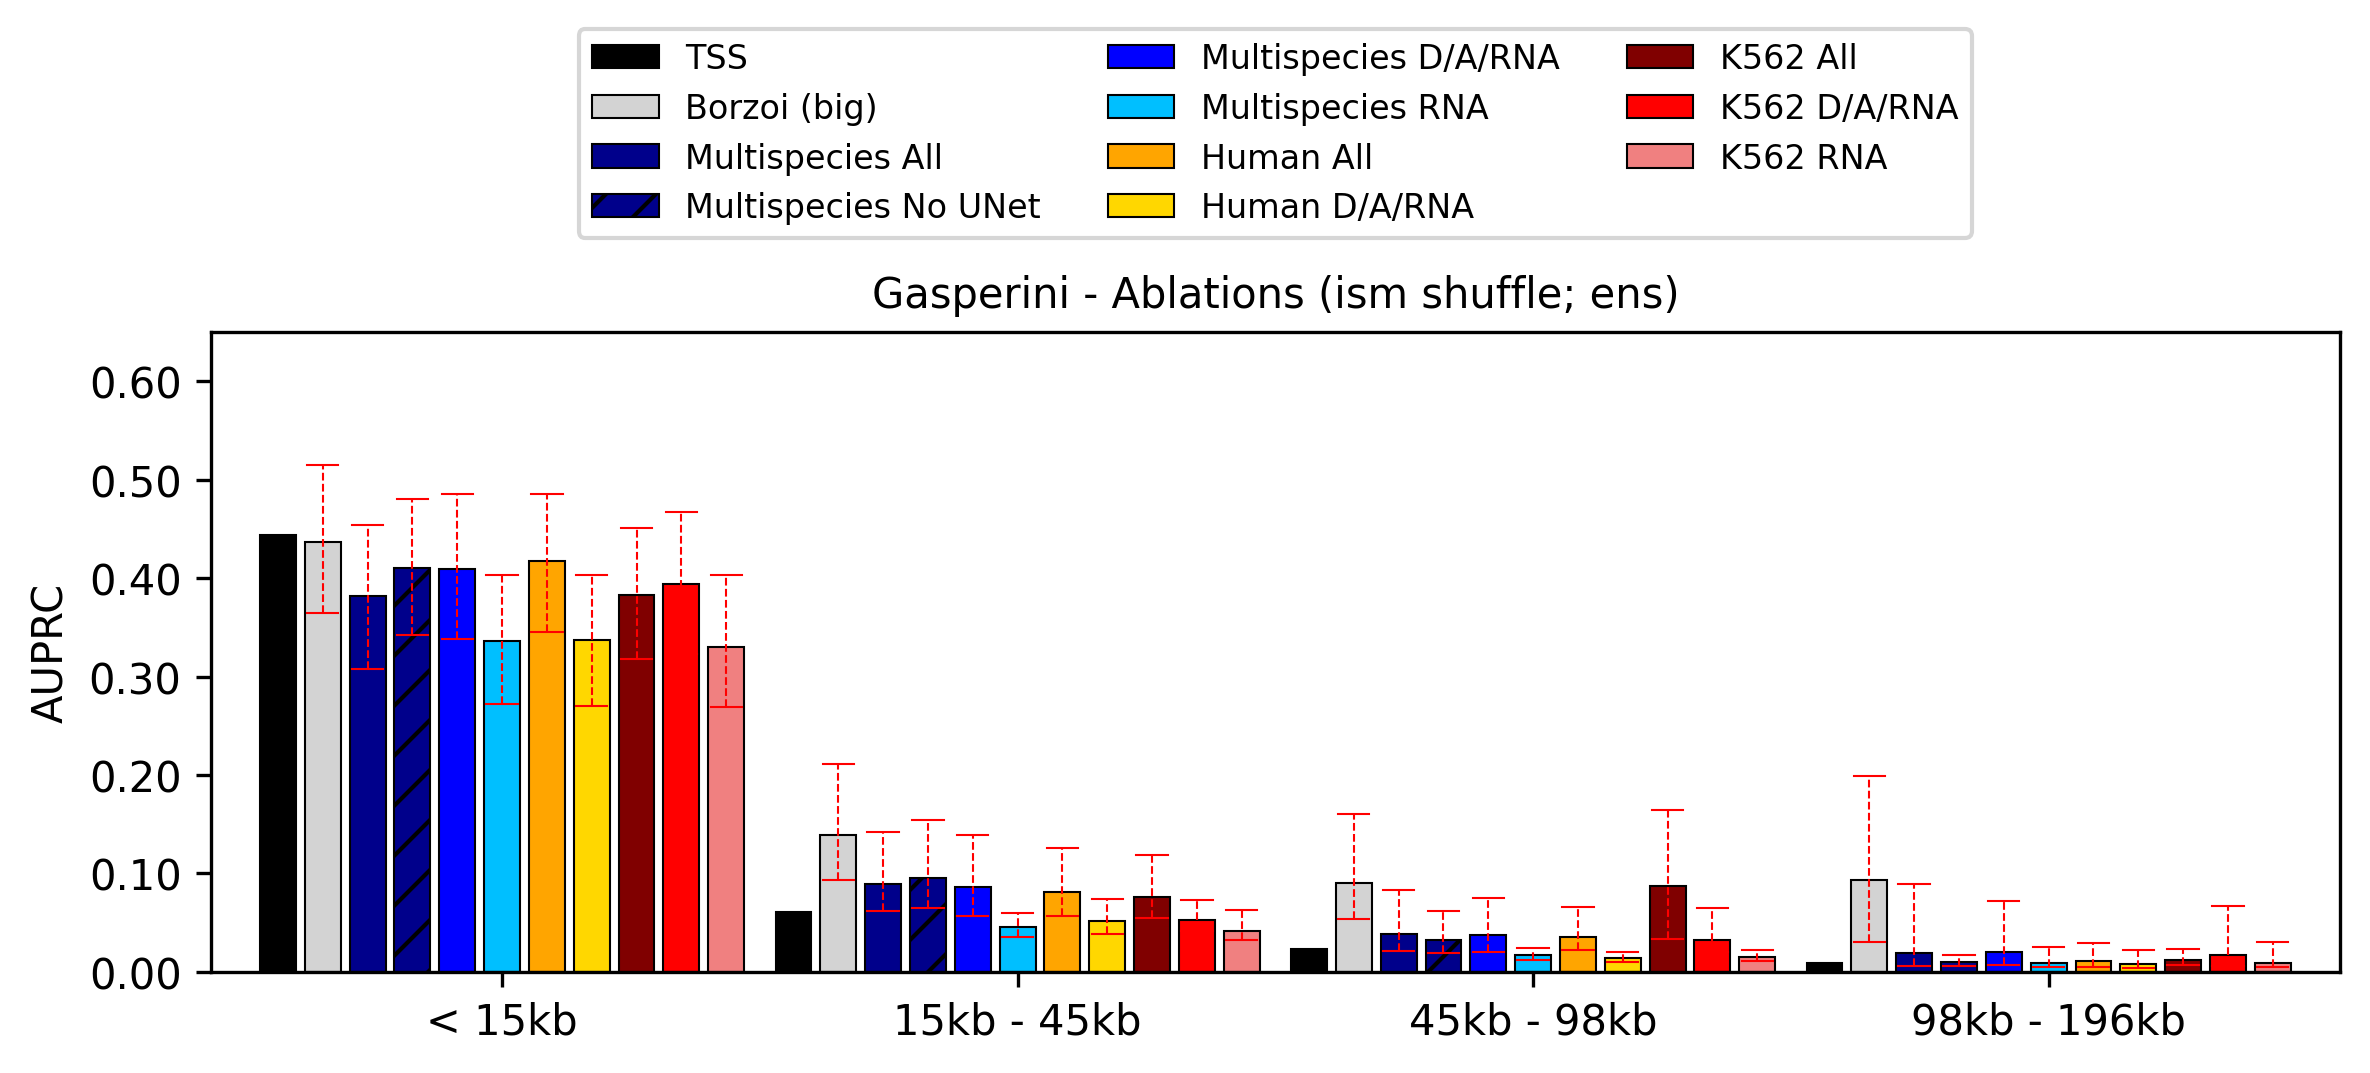

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


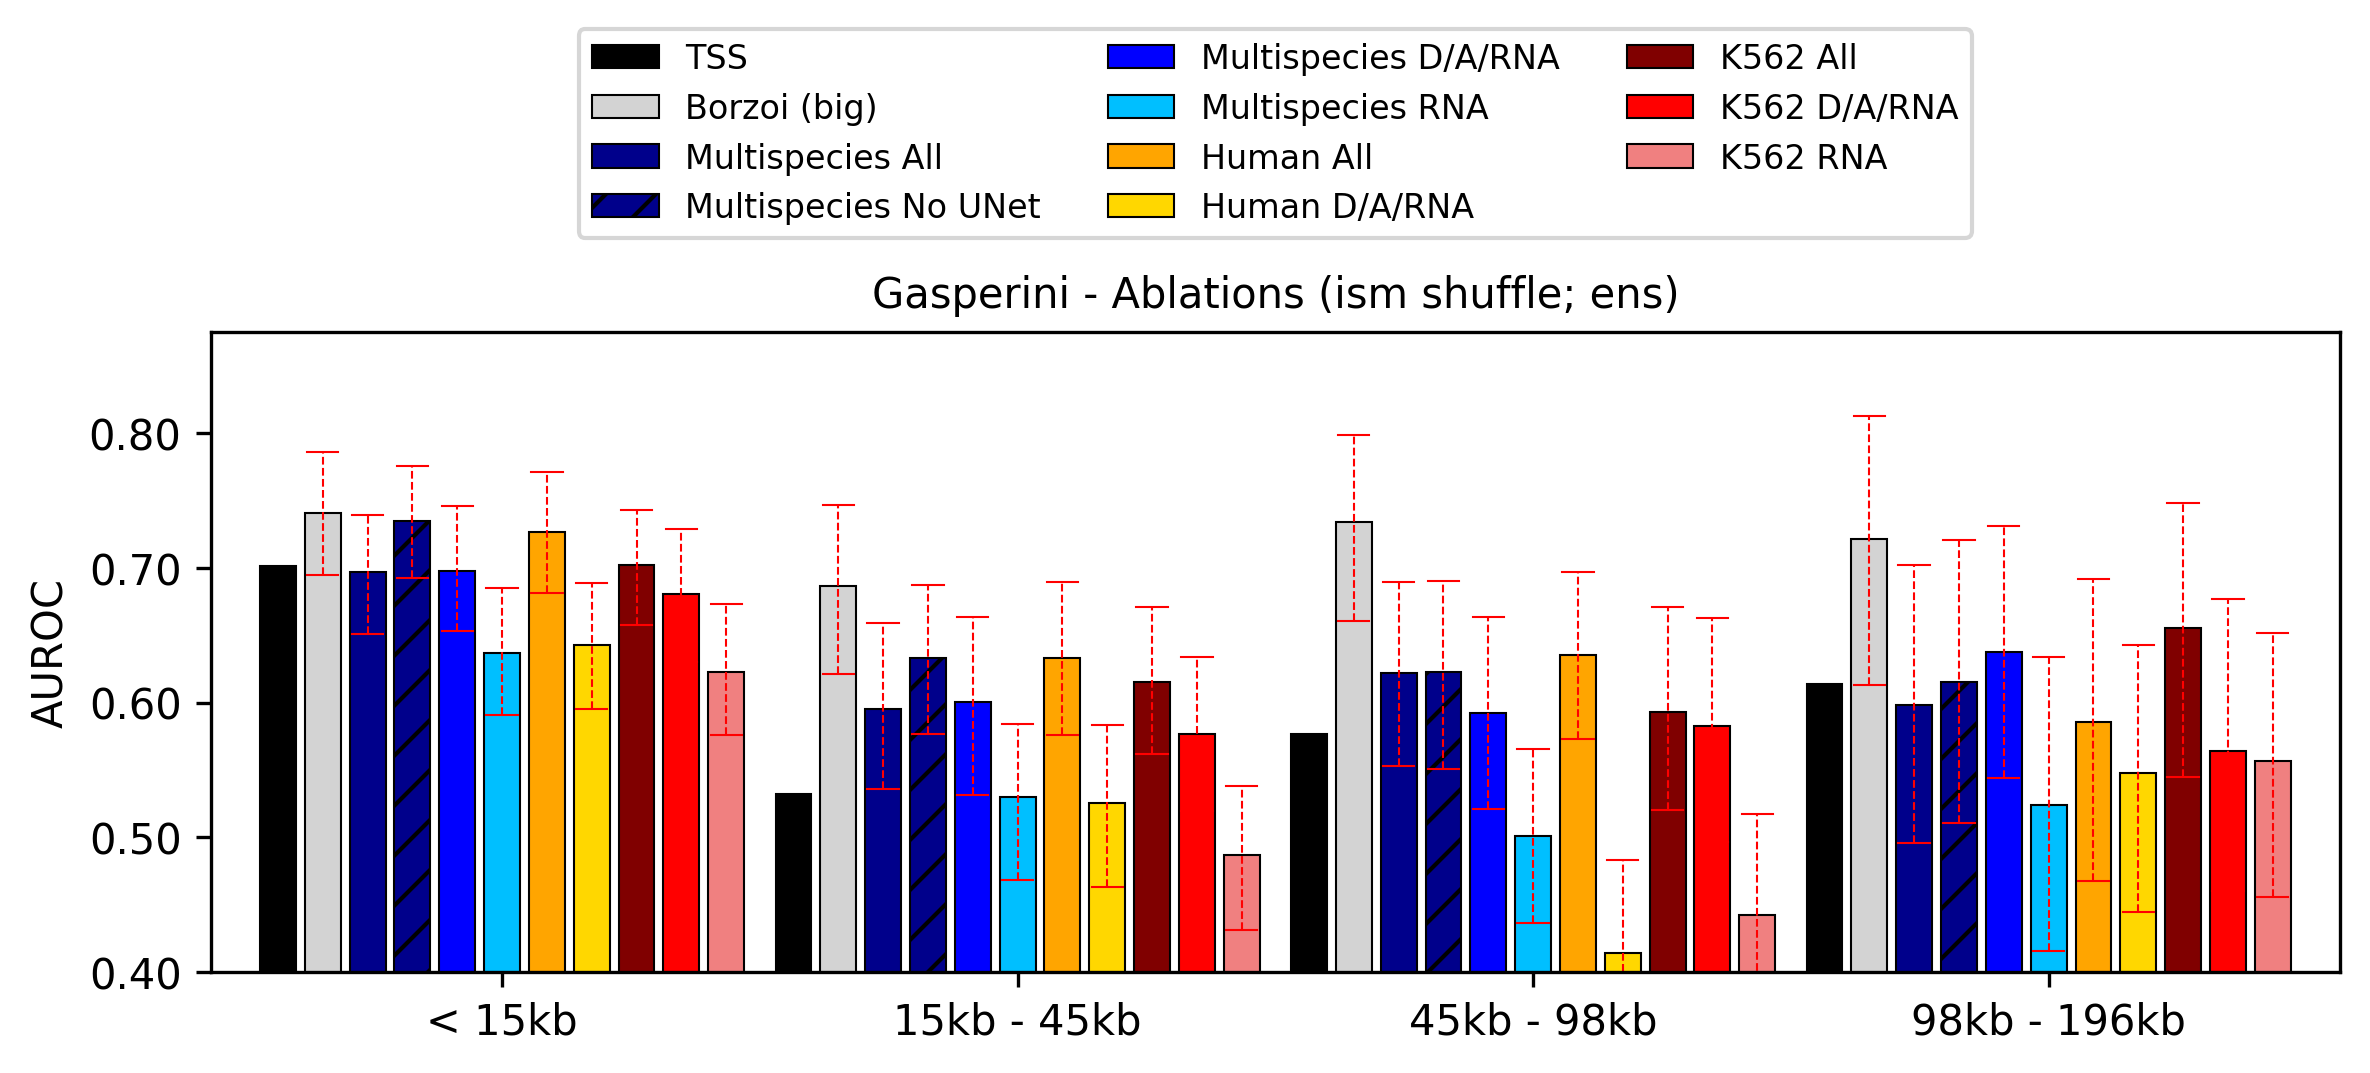

In [16]:
#Plot AUPRC bar chart with perfomance metrics (mini borzoi ablations)

#Model names
model_names = [
    'TSS',
    'Borzoi (big)',
    'Multispecies All',
    'Multispecies No UNet',
    'Multispecies D/A/RNA',
    'Multispecies RNA',
    'Human All',
    'Human D/A/RNA',
    'K562 All',
    'K562 D/A/RNA',
    'K562 RNA',
]

#Stats dataframes
model_dfs = [
    stats_df_tss,
    stats_df_borzoi_ism,
    stats_df_miborzoi_baseline_ism,
    stats_df_miborzoi_multisp_no_unet_ism,
    stats_df_miborzoi_multisp_dnase_atac_rna_ism,
    stats_df_miborzoi_multisp_rna_ism,
    stats_df_miborzoi_human_all_ism,
    stats_df_miborzoi_human_dnase_atac_rna_ism,
    stats_df_miborzoi_k562_all_ism,
    stats_df_miborzoi_k562_dnase_atac_rna_ism,
    stats_df_miborzoi_k562_rna_ism,
]

#Model colors
model_colors = [
    'black',
    'lightgray',
    'darkblue',
    'darkblue',
    'blue',
    'deepskyblue',
    'orange',
    'gold',
    'maroon',
    'red',
    'lightcoral',
]

#Model hatch texture
model_hatches = [
    None,
    None,
    None,
    '//',
    None,
    None,
    None,
    None,
    None,
    None,
    None,
]

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='Gasperini - Ablations (ism shuffle; ens)',
    metric='ap',
    metric_str='AUPRC',
    distances=[15000, 45000, 98000, 196000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 196kb'],
    y_min=0.0,
    y_max=0.65,
    save_name='gasperini_miborzoi_ism_bench_prc_w_borzoi'
)

#Plot AUROC bar chart

plot_bars(
    model_names,
    model_dfs,
    model_colors,
    model_hatches=model_hatches,
    limit_x=True,
    legend_outside=True,
    fig_size=(8, 4.25),
    plot_title='Gasperini - Ablations (ism shuffle; ens)',
    metric='auc',
    metric_str='AUROC',
    distances=[15000, 45000, 98000, 196000],
    distance_strs=['< 15kb', '15kb - 45kb', '45kb - 98kb', '98kb - 196kb'],
    y_min=0.4,
    y_max=0.875,
    save_name='gasperini_miborzoi_ism_bench_roc_w_borzoi'
)
